In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import sys
import os
import h5py
import copy
from IPython import display

/home/qnl/miniconda3/envs/qutip-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


# Custom training

## load data

In [2]:
head = "/home/qnl/noah/traj/deep_learning_analysis"
filename = os.path.join(head, "manu_dataset.h5")
load_data_dict = dict()
with h5py.File(filename, 'r') as f:
    # List all groups
    keys_list = [key for key in f.keys()]
    
    # get data
    for key in keys_list:
        load_data_dict[key] = np.array(f[key])
    print('data_loaded to load_data_dict')

data_loaded to load_data_dict


In [3]:
vrec_len = np.shape(load_data_dict['eval_data'])[-1]

## define model

#### custom layers

In [4]:
_static_batch_size_ = 32
lstm_units = 20
kernel_reg = 0.005
activity_reg = 0.005
lstm_kernel_l1 = 0.01
lstm_kernel_l2 = 0.01

In [5]:
voltage_records = keras.Input(shape=(vrec_len, 1), name='voltage_record_input', batch_size=_static_batch_size_)
# prep_states = keras.Input(shape=(3, 1), name='prep_state_input', batch_size=_static_batch_size_)  # remember to flatten input
prep_states = keras.Input(shape=(3,), name='prep_state_input', batch_size=_static_batch_size_)  # remember to flatten input
mask = keras.Input(shape=(vrec_len), name='mask', batch_size=_static_batch_size_, dtype='bool')
# is_training = keras.Input(shape=(1), name='is_training', dtype='bool')

# dense for initial states of lstm
# TODO: use embedding layer here
h_init = keras.layers.Dense(units=lstm_units, 
                            input_shape=(3,),
                            activation='relu',
                            kernel_initializer='he_normal',
                            bias_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(kernel_reg),
                            activity_regularizer=keras.regularizers.l2(activity_reg),
                            name='h_init_dense')(prep_states)
h_init = keras.layers.Dropout(rate=0.1, name='h_init_dropout')(h_init)
c_init = keras.layers.Dense(units=lstm_units, 
                            input_shape=(3,),
                            activation='relu',
                            kernel_initializer='he_normal',
                            bias_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(kernel_reg),
                            activity_regularizer=keras.regularizers.l2(activity_reg),
                            name='c_init_dense')(prep_states)
c_init = keras.layers.Dropout(rate=0.1, name='c_init_dropout')(c_init)

lstm_out = keras.layers.LSTM(units=lstm_units,
                             input_shape=(vrec_len, 1),
                             return_sequences=True,
                             activation='tanh', 
                             kernel_initializer = 'glorot_normal', 
                             use_bias=True,
                             bias_initializer='glorot_normal',
                             recurrent_activation='sigmoid',
                             recurrent_initializer='glorot_normal',
                             kernel_regularizer=keras.regularizers.l1_l2(l1=lstm_kernel_l1, l2=lstm_kernel_l2),
                             name='lstm',
                             dropout=0.3,
                             recurrent_dropout=0.3,
                             unroll=True)(initial_state=[h_init, c_init],
                                          inputs=voltage_records,
                                          mask=mask,
                                         )
lstm_out = keras.layers.Dropout(rate=0.1, name='lstm_out_dropout')(lstm_out)
lstm_out = tf.expand_dims(lstm_out, -1, name='expand_dims_for_Conv2D')  # add dimensions to satisfy keras Conv2D input dimensionality requirements
# fixme: edges will be ignored for outputs 0 and 2; need custom layer here
p_out_full = keras.layers.Conv2D(filters=3,
                                 kernel_size=(1, lstm_units),
                                 data_format='channels_last',
                                 name='dim_reduction_for_prob',
                                 activation='sigmoid',
                                 kernel_initializer = 'glorot_normal', 
                                 bias_initializer='glorot_normal',
                                 use_bias=True,
                                 kernel_regularizer=keras.regularizers.l2(kernel_reg),
                                 activity_regularizer=keras.regularizers.l2(activity_reg),
                                 )(lstm_out)
p_out_full = tf.squeeze(p_out_full, axis=-2, name='remove_len1_dims')  # remove length-1 dims; want to output this somehow
model = keras.Model(inputs=(voltage_records, prep_states, mask), outputs=p_out_full, name='first_trajectories_rnn')
model.summary()

Model: "first_trajectories_rnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
prep_state_input (InputLayer)   [(32, 3)]            0                                            
__________________________________________________________________________________________________
h_init_dense (Dense)            (32, 20)             80          prep_state_input[0][0]           
__________________________________________________________________________________________________
c_init_dense (Dense)            (32, 20)             80          prep_state_input[0][0]           
__________________________________________________________________________________________________
voltage_record_input (InputLaye [(32, 108, 1)]       0                                            
_____________________________________________________________________________

In [6]:
# model.get_config()

### cast np arrays to tf datasets

In [7]:
tf_data_load = {key : tf.data.Dataset.from_tensor_slices(load_data_dict[key]) for key in list(load_data_dict.keys())}

In [8]:
tf_data_load['eval_data']

<TensorSliceDataset shapes: (108,), types: tf.float64>

### note on training:
two ways we can do this:
1. train on sinle label of output where we encode the output with some encoder layer and then translate this to trajectories in numpy (more similar to manu)
2. train on probabilities from output 

### mask for RNN inputs

In [9]:
mask = copy.deepcopy(load_data_dict['eval_data'])
locs_0 = np.where(load_data_dict['eval_data'] == 0)
mask[locs_0] = 0
mask[np.where(mask != 0)] = 1

# split training and validation data

In [10]:
batch_size = 1024

In [11]:
validation_split = 0.1
num_iters = np.shape(load_data_dict['eval_prep_retro'])[0]
train_iters = int(num_iters*(1 - validation_split))
print(num_iters, train_iters)

74204 66783


In [12]:
full_dataset = tf.data.Dataset.from_tensor_slices((load_data_dict['eval_data'], # voltage records
                                                    load_data_dict['eval_prep'], # preparation 
                                                    load_data_dict['eval_time'], # select time step
                                                    load_data_dict['eval_prep_retro'],  # actual labels to train on
                                                    mask,  # RNN mask
                                                ))
# full_dataset = full_dataset.shuffle(num_iters)

In [13]:
_train_dataset = full_dataset.take(train_iters)
train_dataset = _train_dataset.batch(batch_size=batch_size, drop_remainder=True)

_test_dataset = full_dataset.skip(train_iters)
test_dataset = _test_dataset.batch(batch_size=int((num_iters - train_iters)), drop_remainder=True)


### define learning rate and dropout rate schedulers

In [14]:
# linear dropout rate scheduler
def dropout_rate_scheduler(epoch, init_rate=0.3, zero_at_epoch=10, arg_divisor=2):
    assert init_rate <= 1 and init_rate >= 0
    if epoch < zero_at_epoch:
        return np.linspace(init_rate, 0, zero_at_epoch)[epoch]
    else:
        return 0

In [15]:
# linear learning rate scheduler
def learning_rate_scheduler(epoch, init_rate=1e-3, final_rate=1e-6, fixed_at_epoch=10, arg_divisor=10):
    if epoch < fixed_at_epoch:
        return np.linspace(init_rate, final_rate, fixed_at_epoch)[epoch]
    else:
        return final_rate

### execute training

In [16]:
epochs = 100
fixed_at_epoch = 79
init_dropout_rate = 0.65
validation_split = None

#### using scheduler

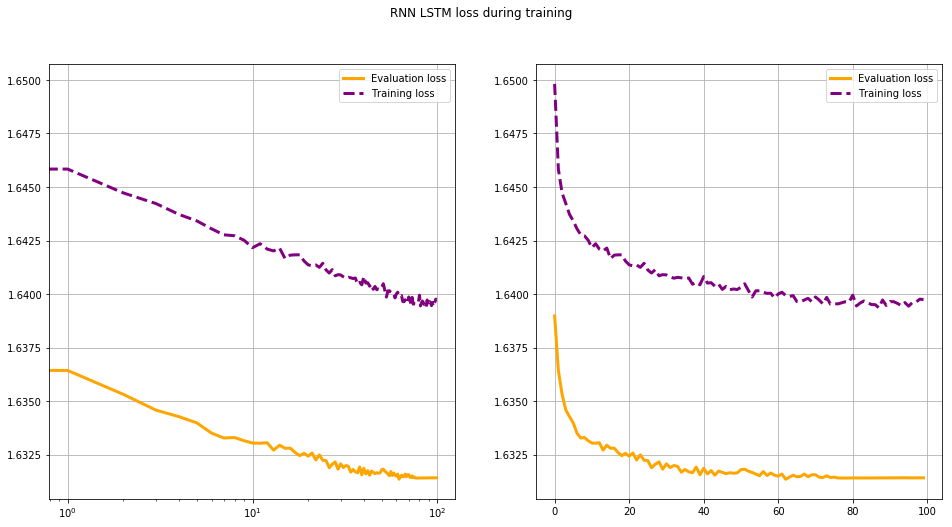

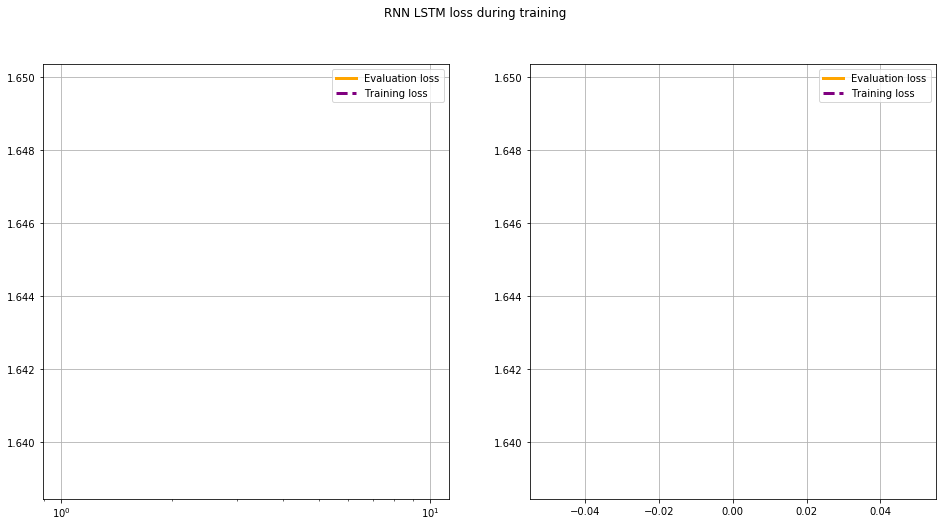

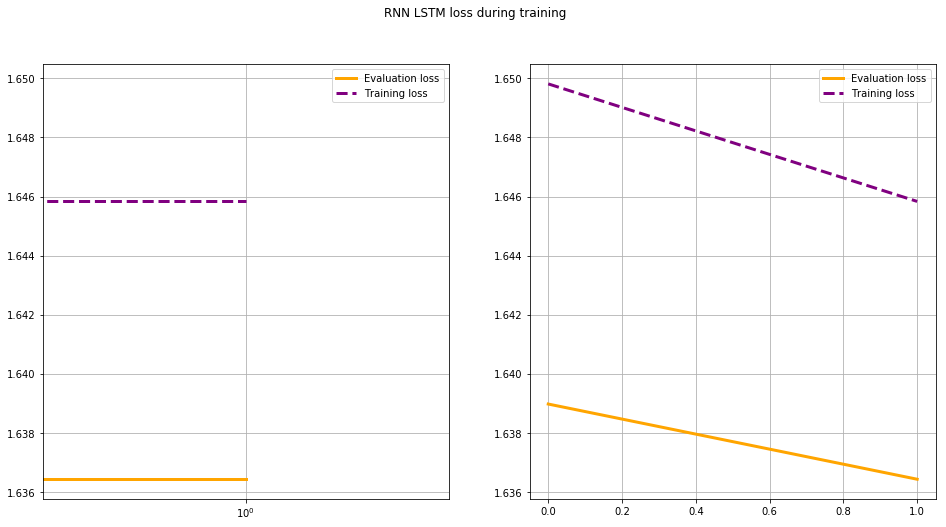

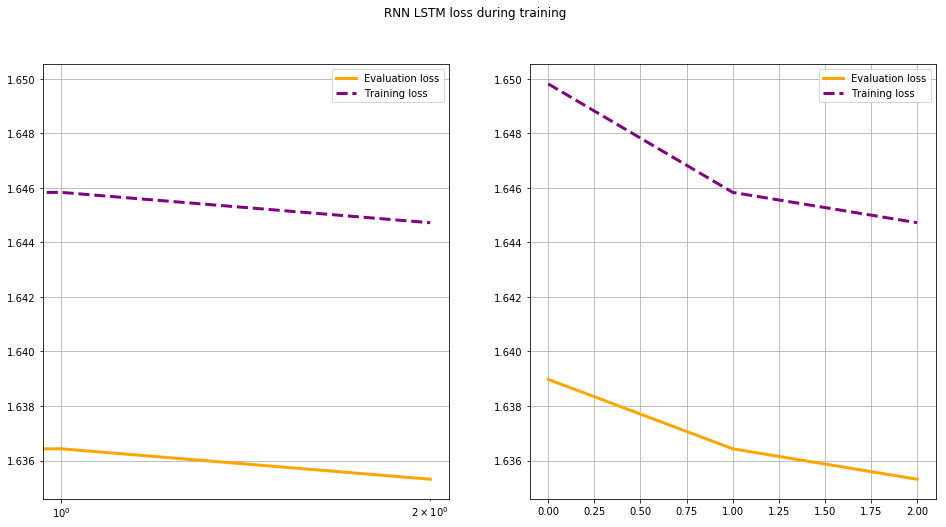

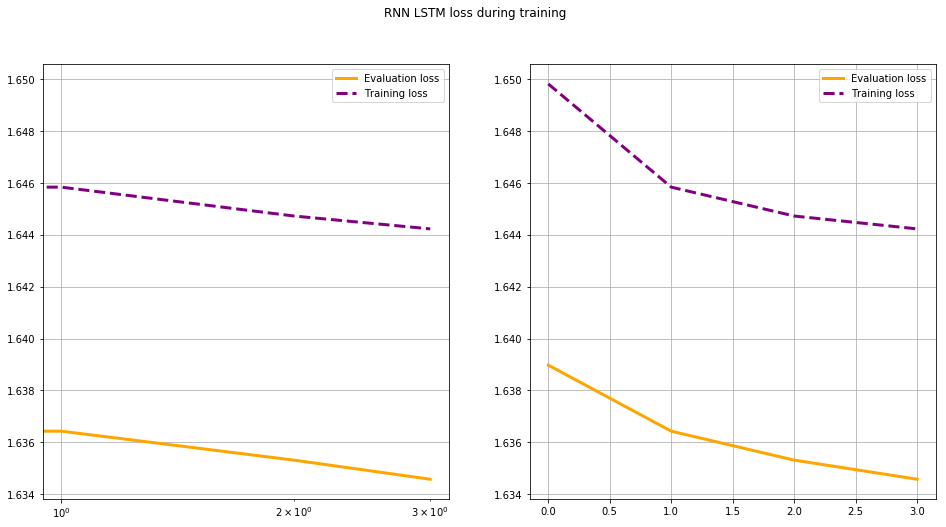

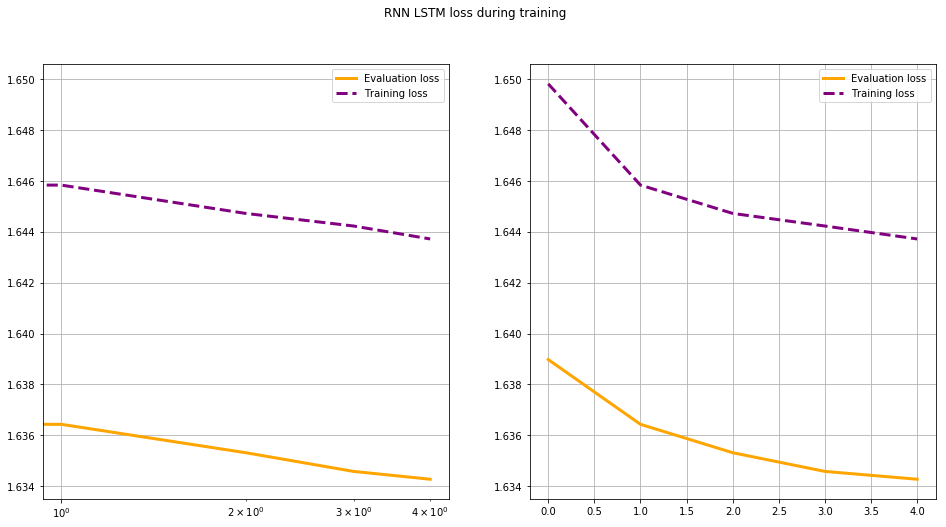

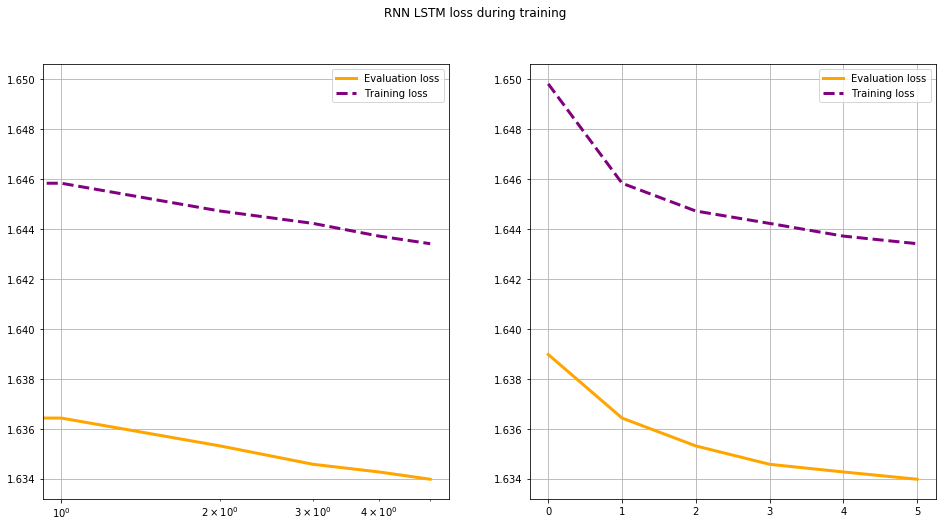

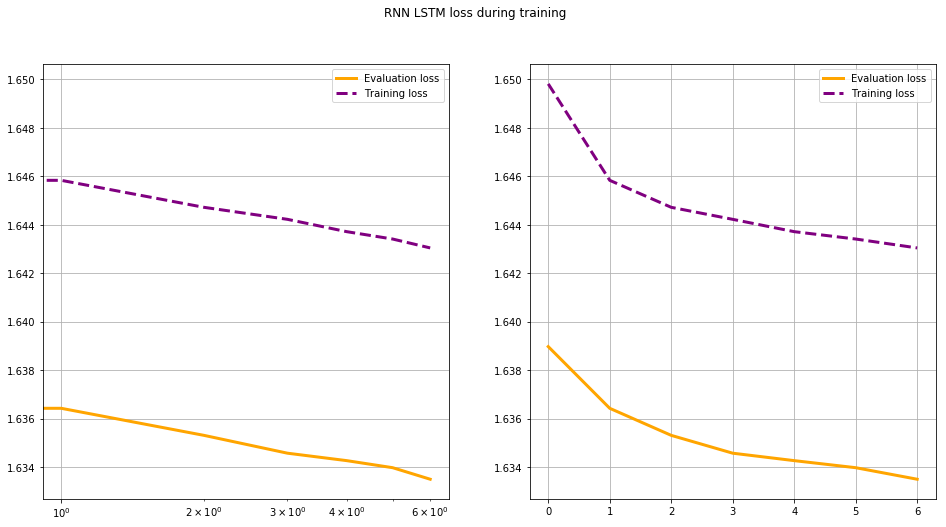

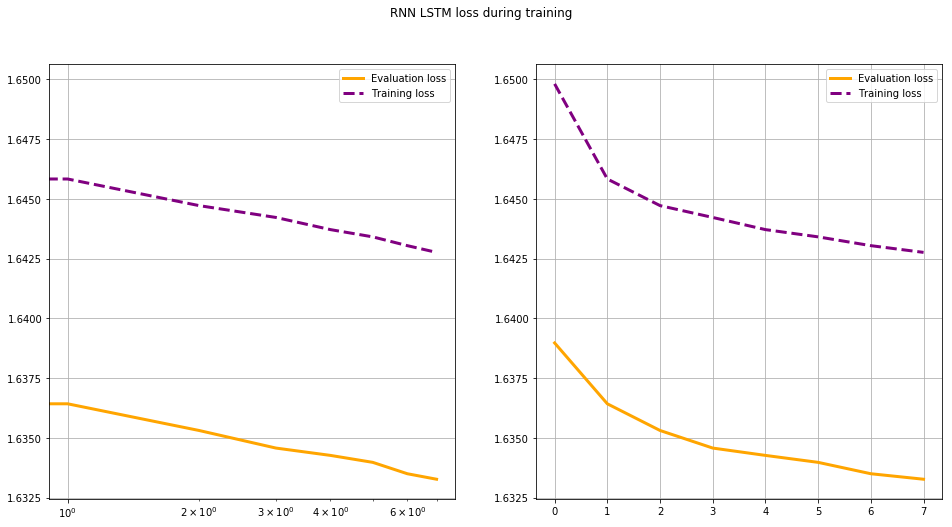

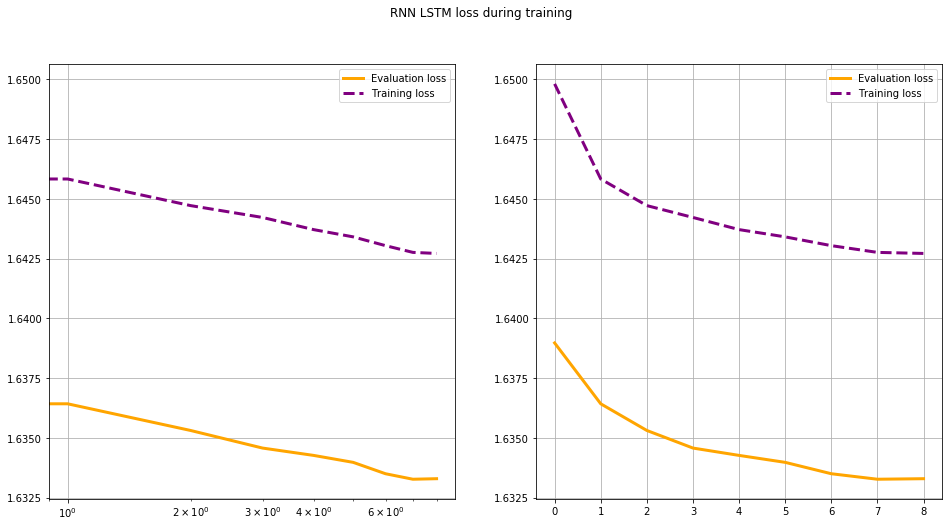

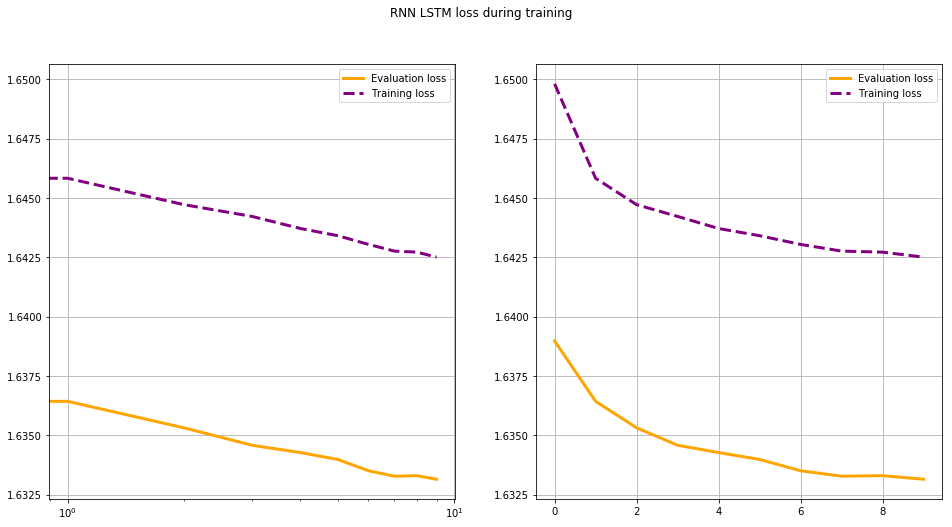

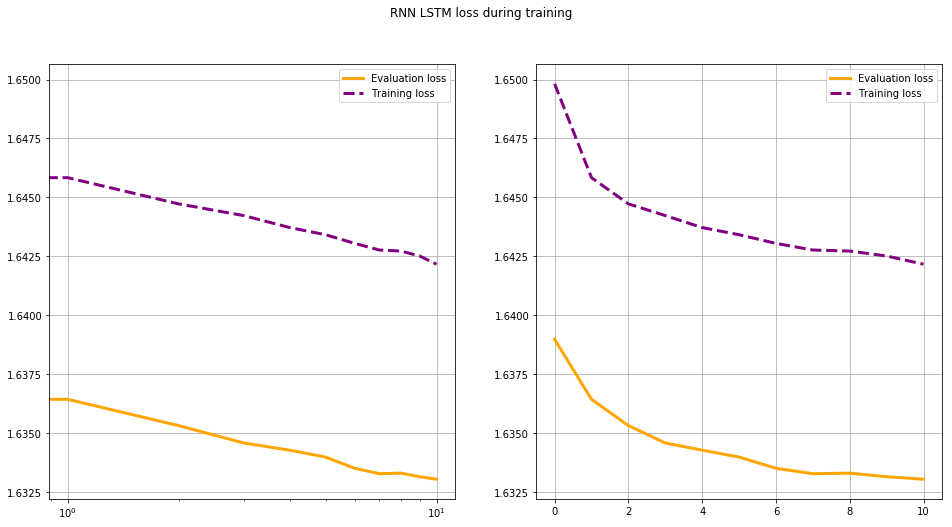

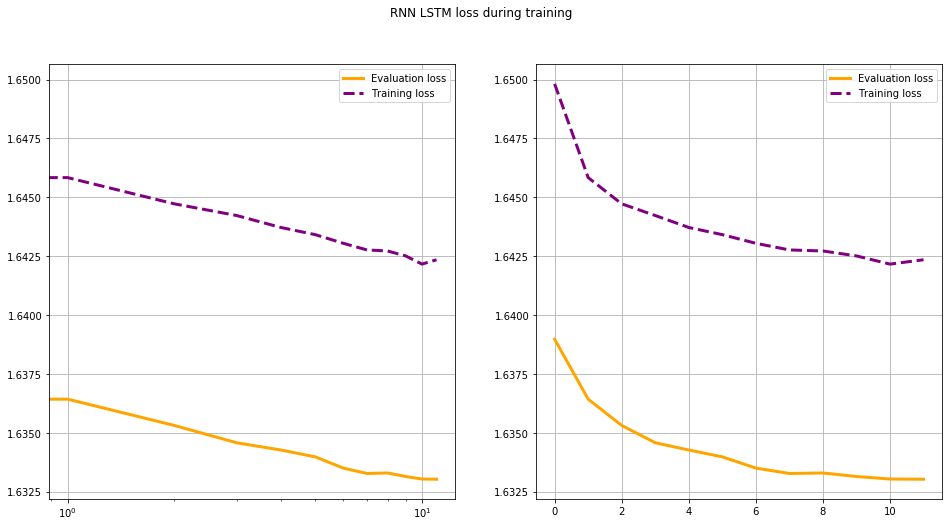

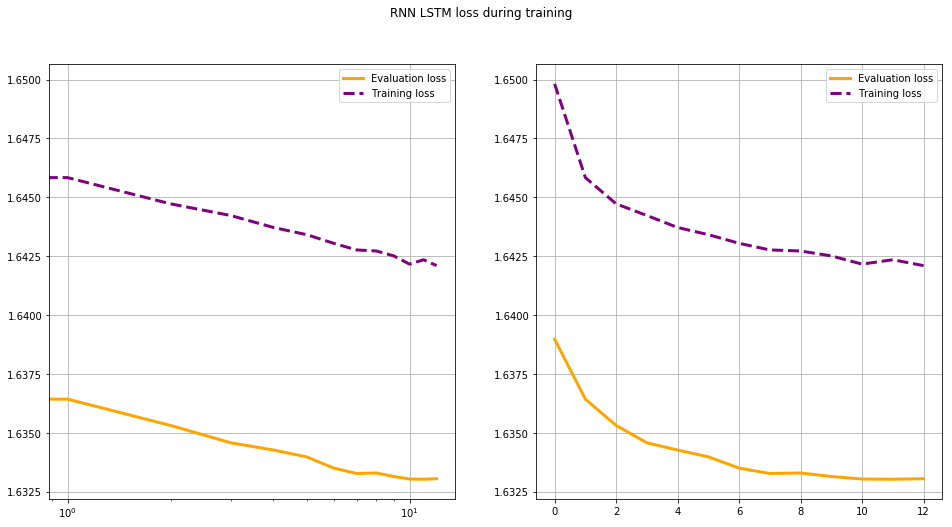

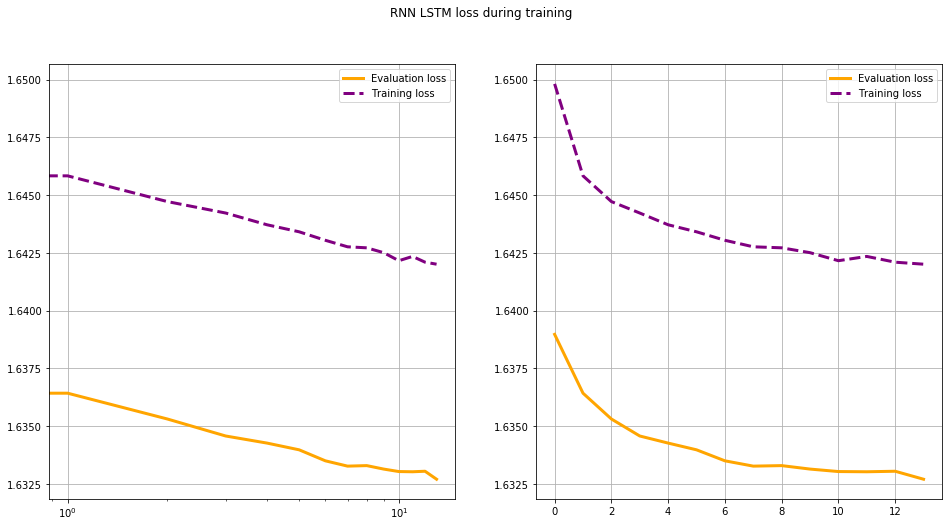

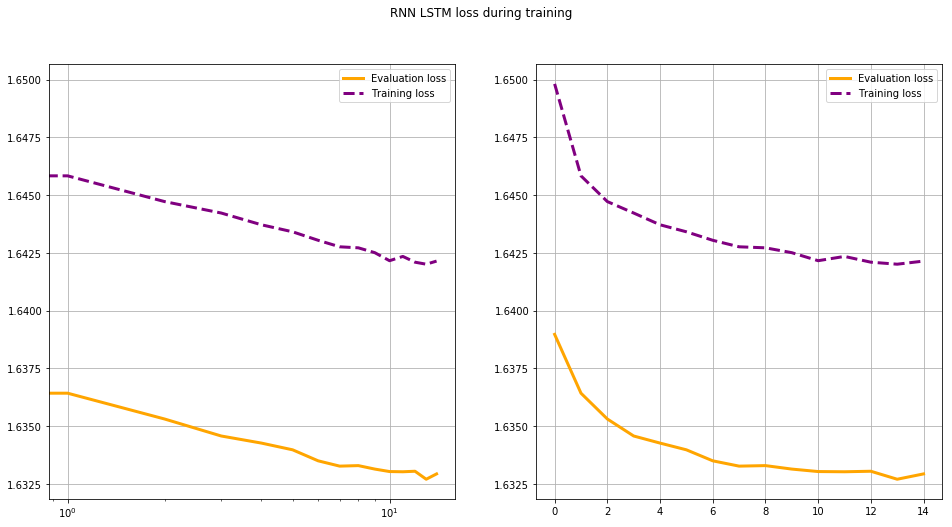

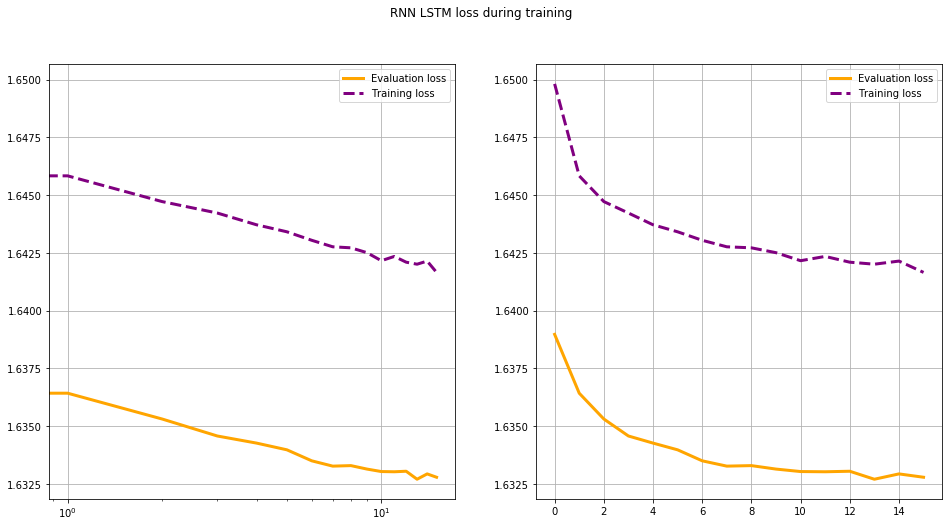

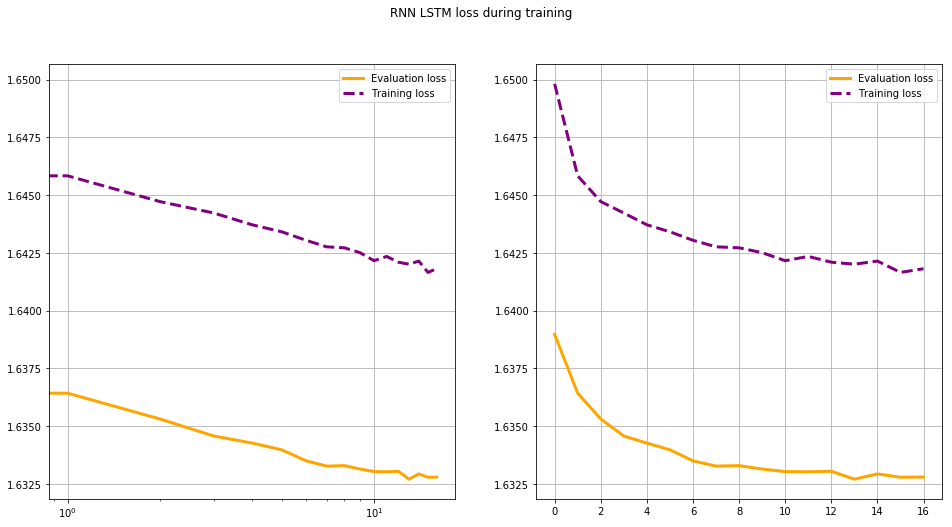

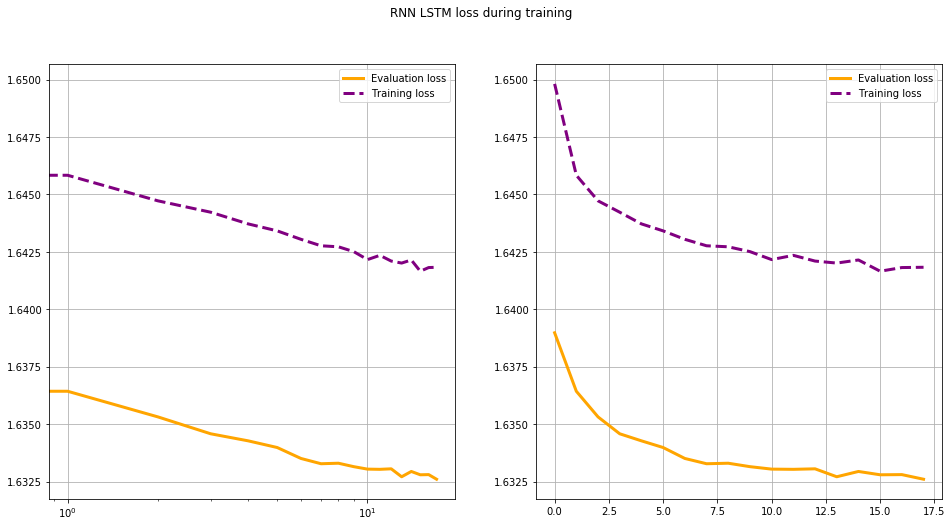

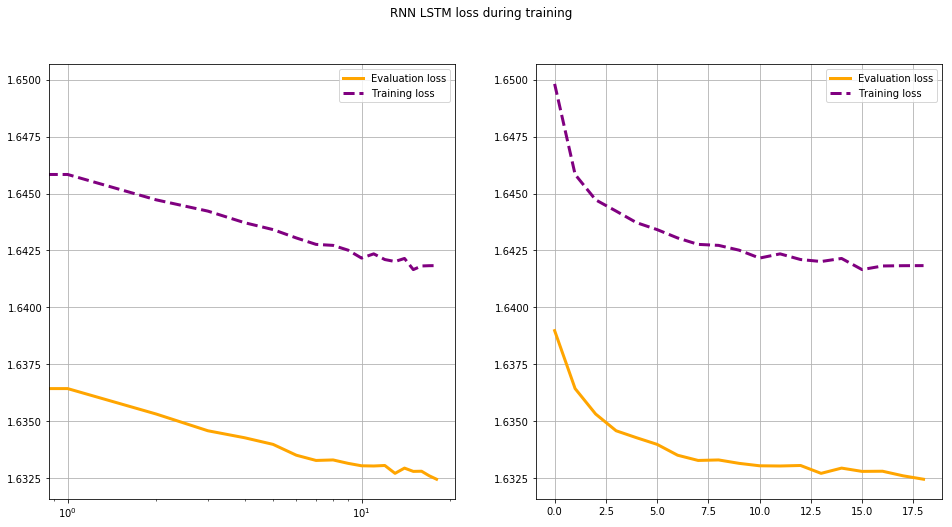

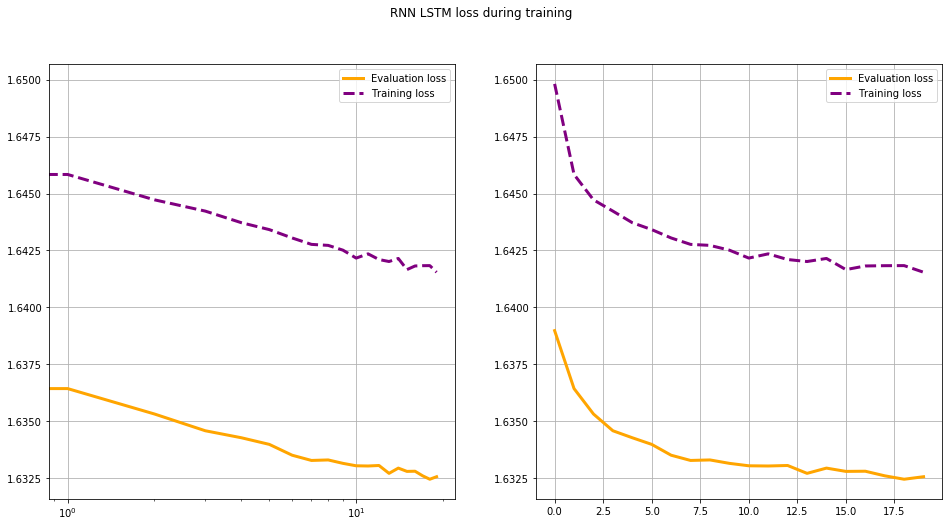

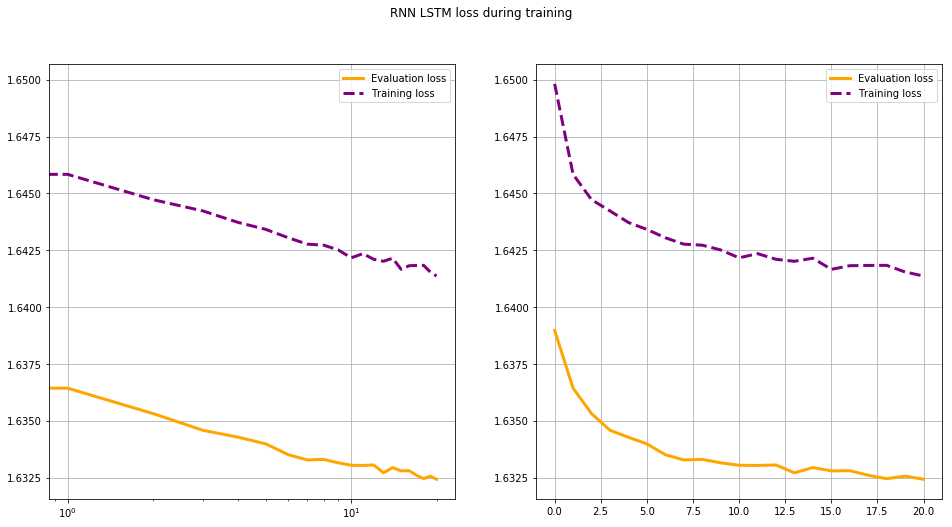

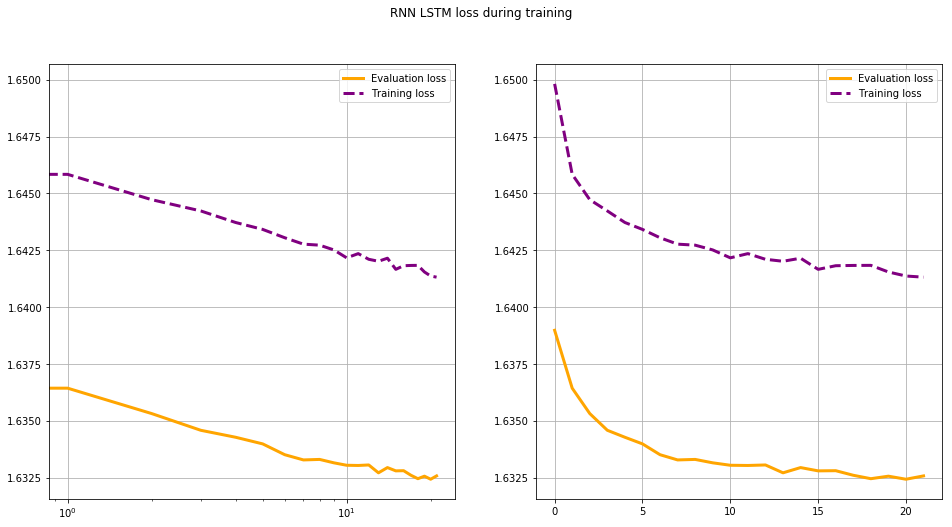

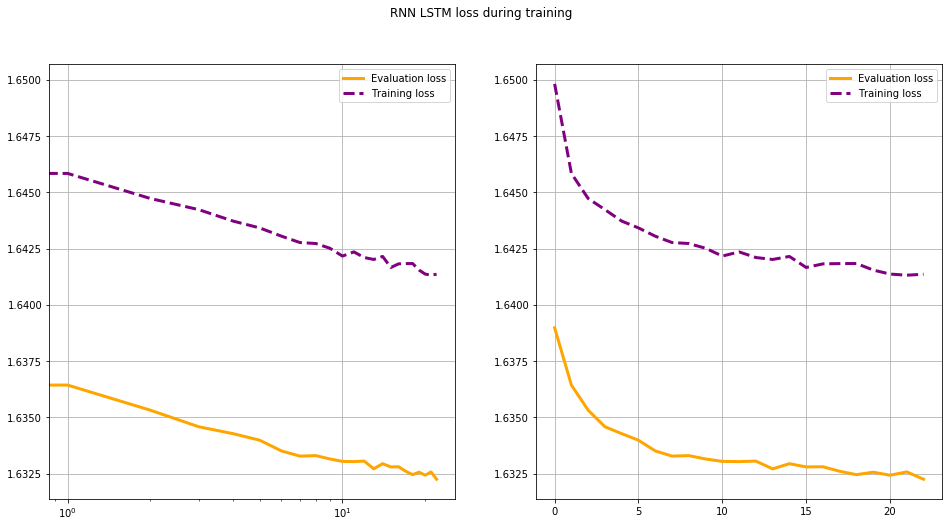

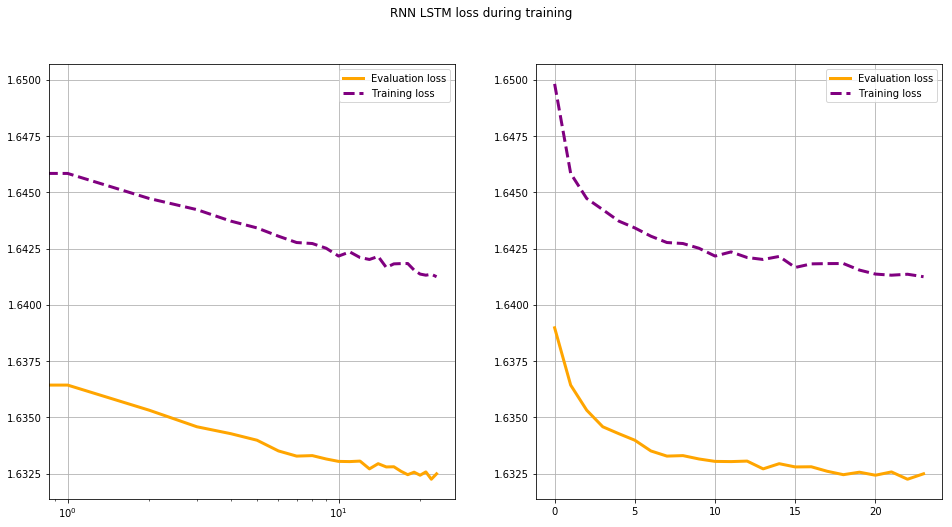

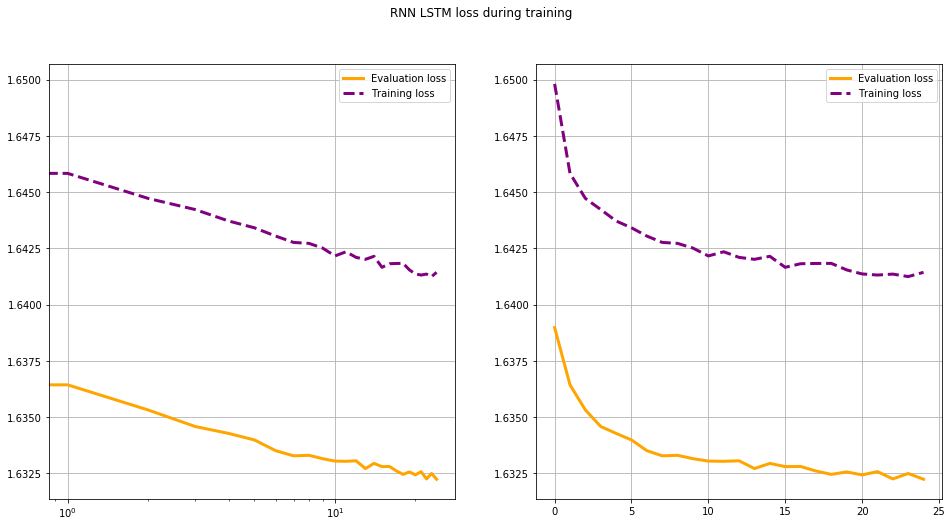

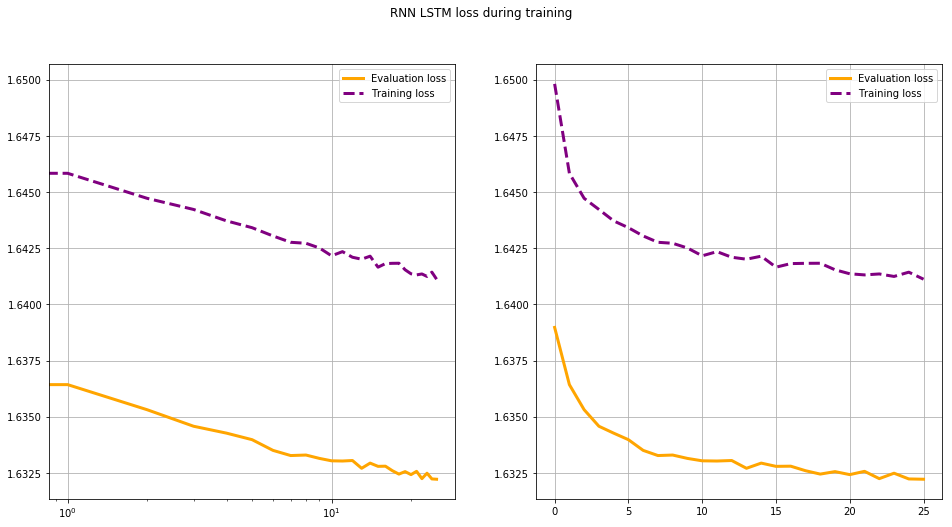

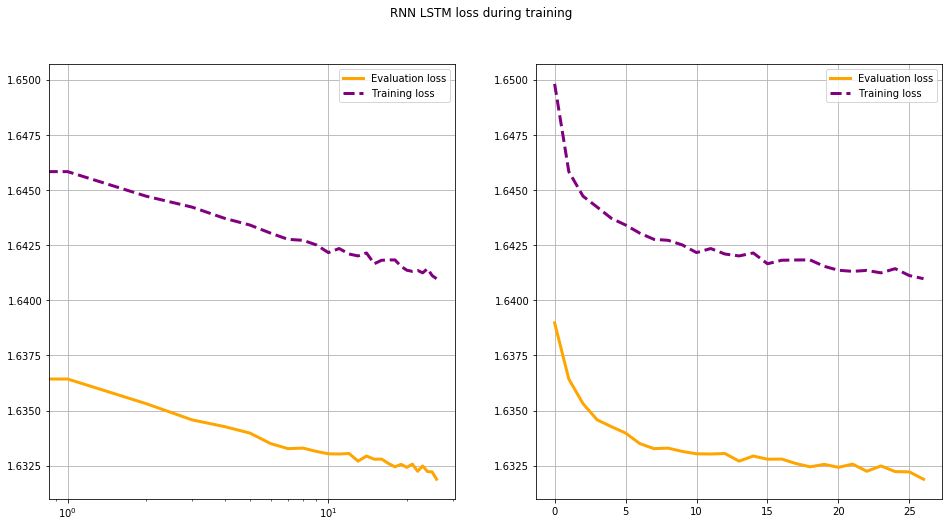

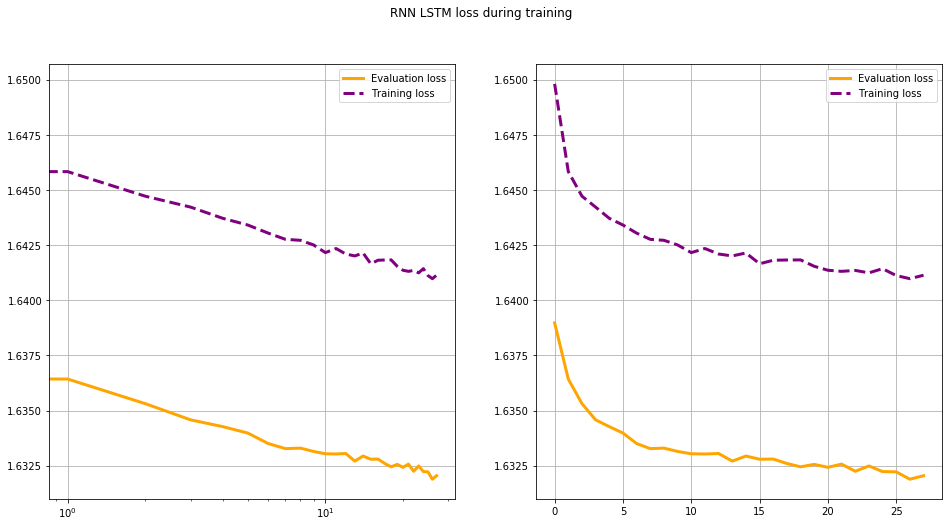

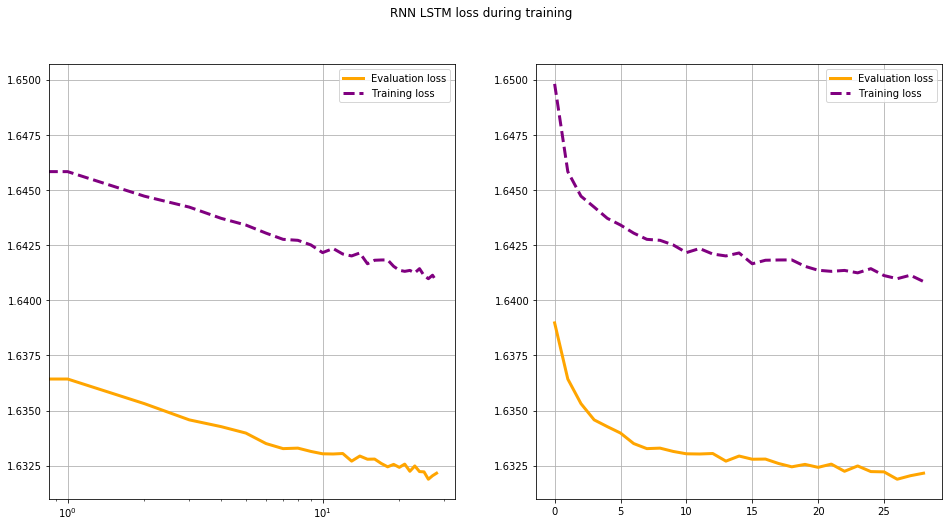

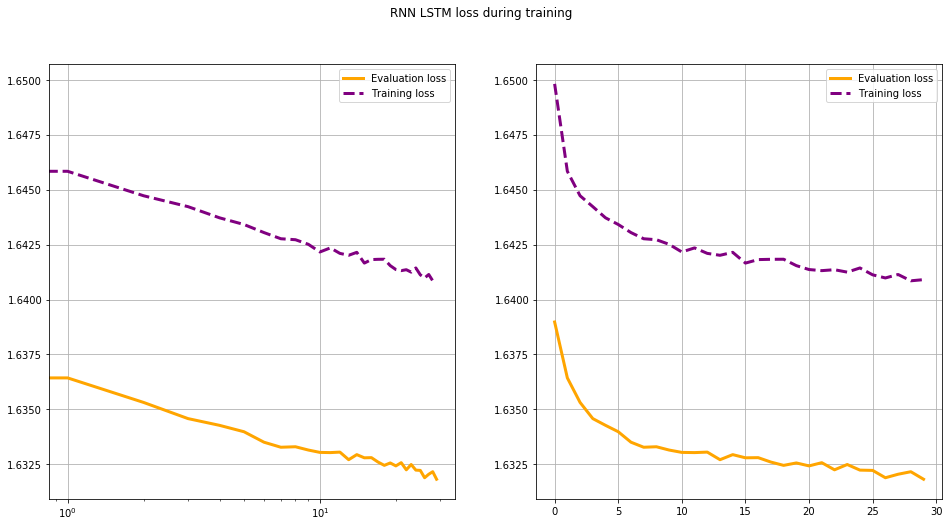

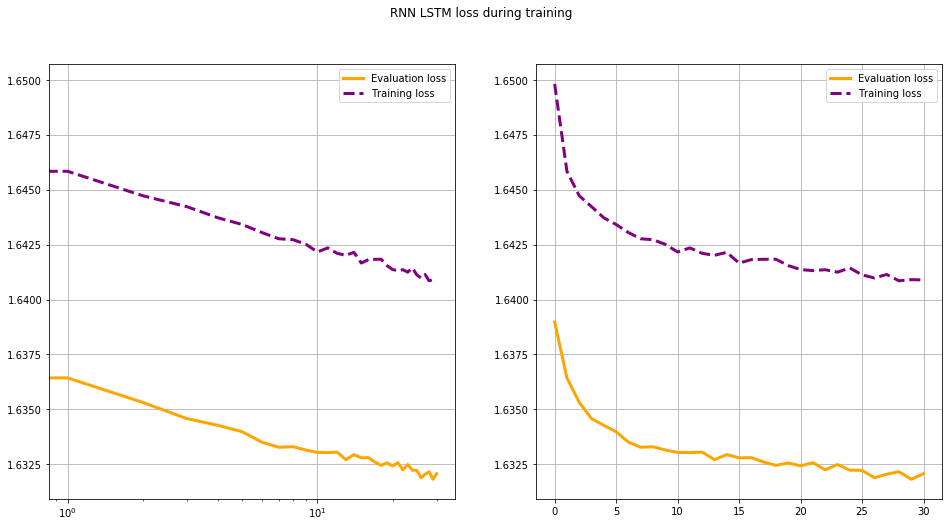

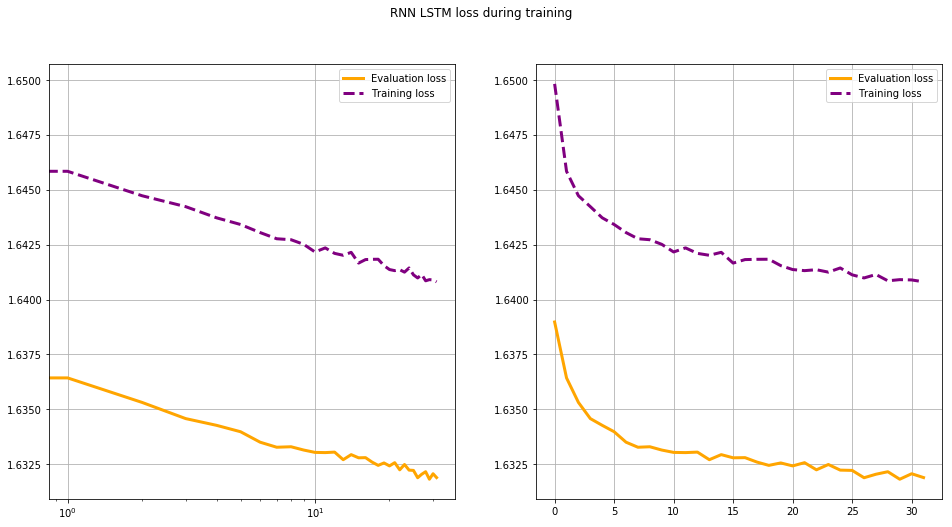

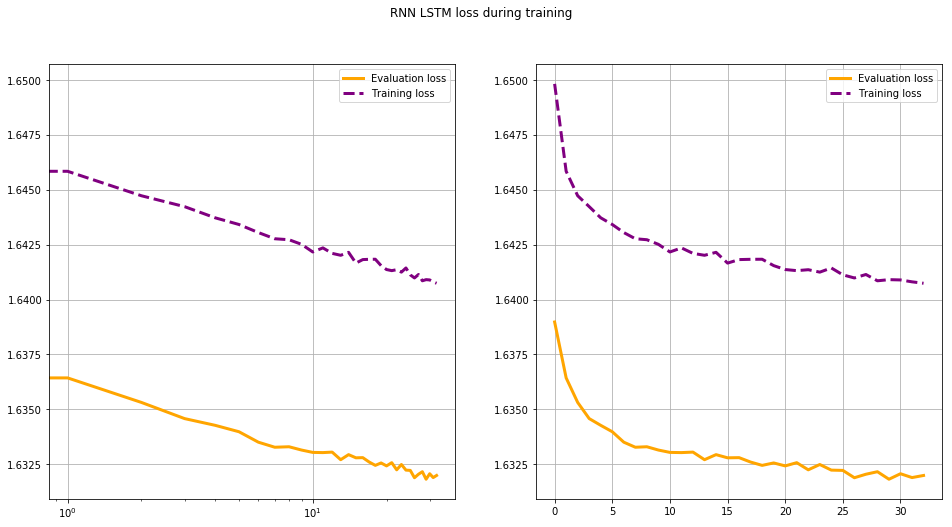

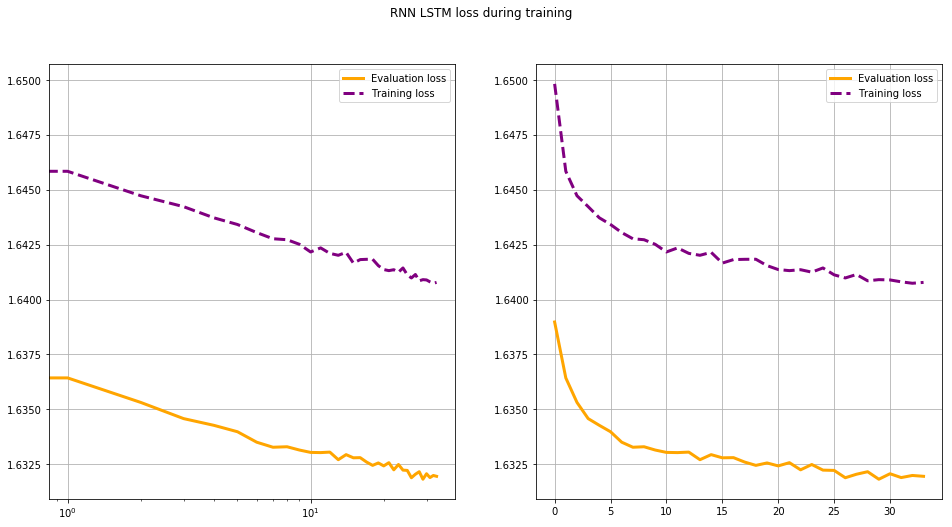

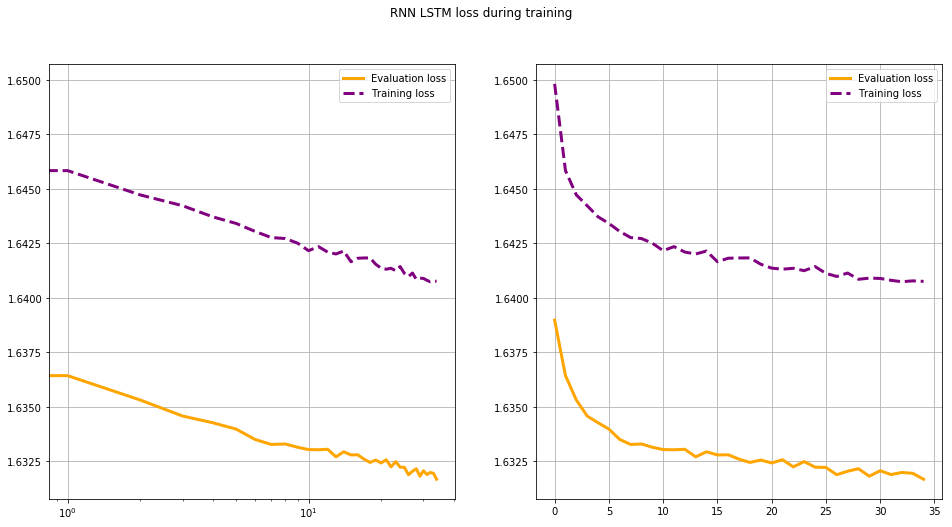

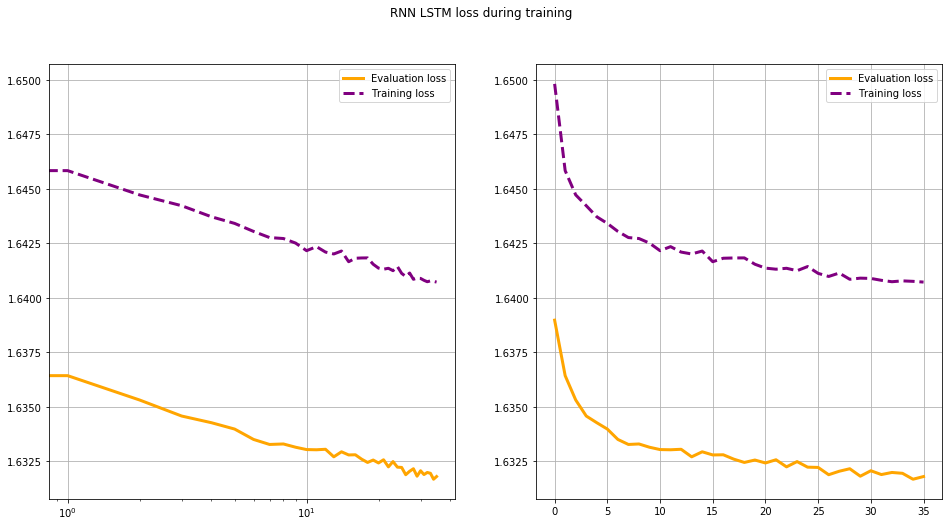

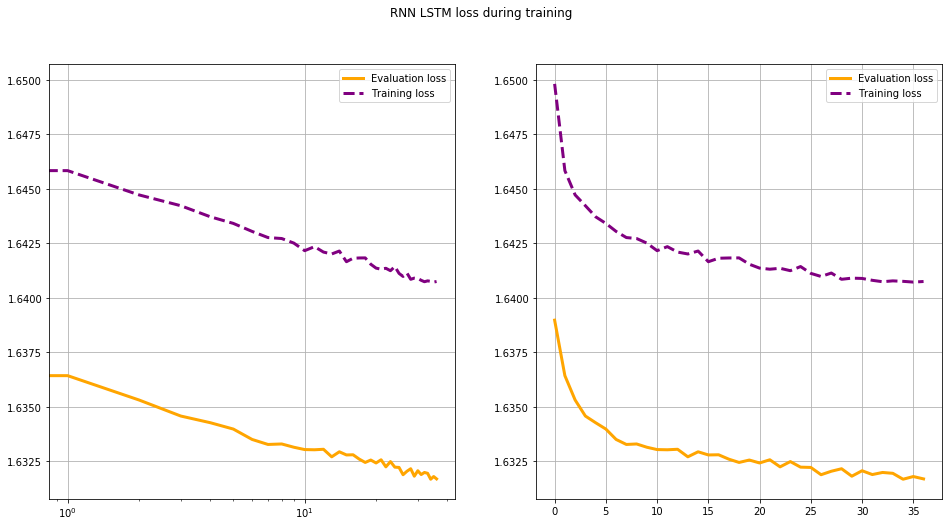

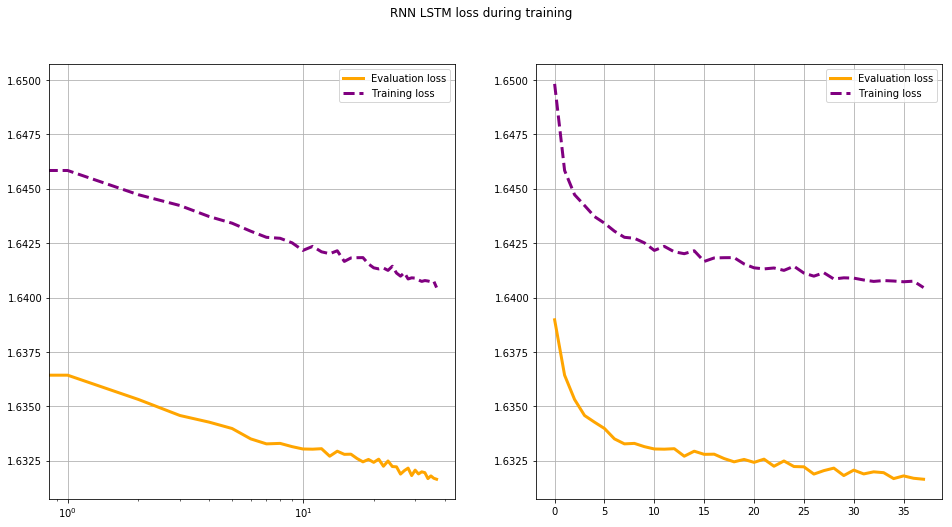

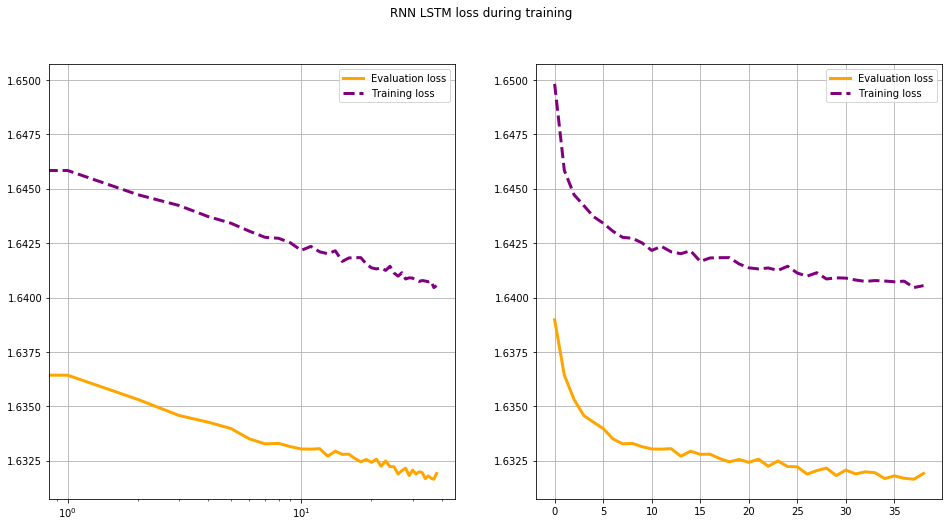

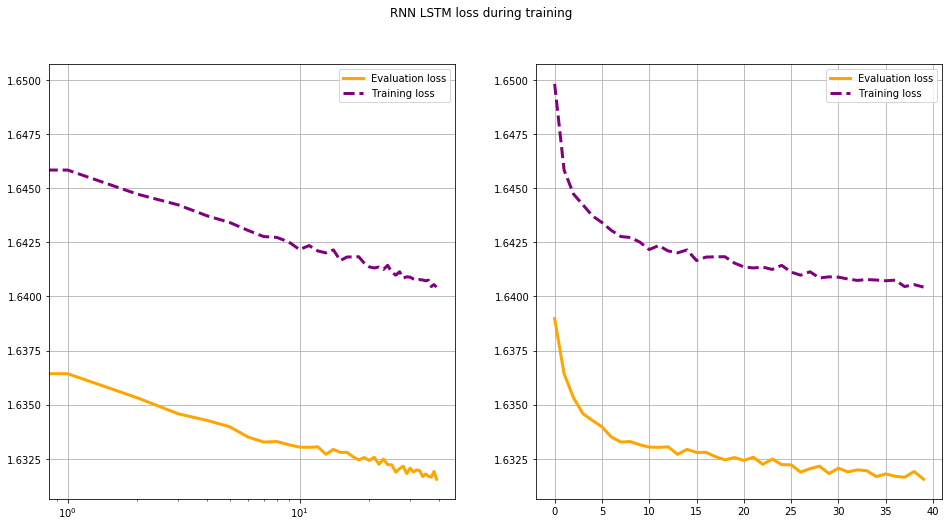

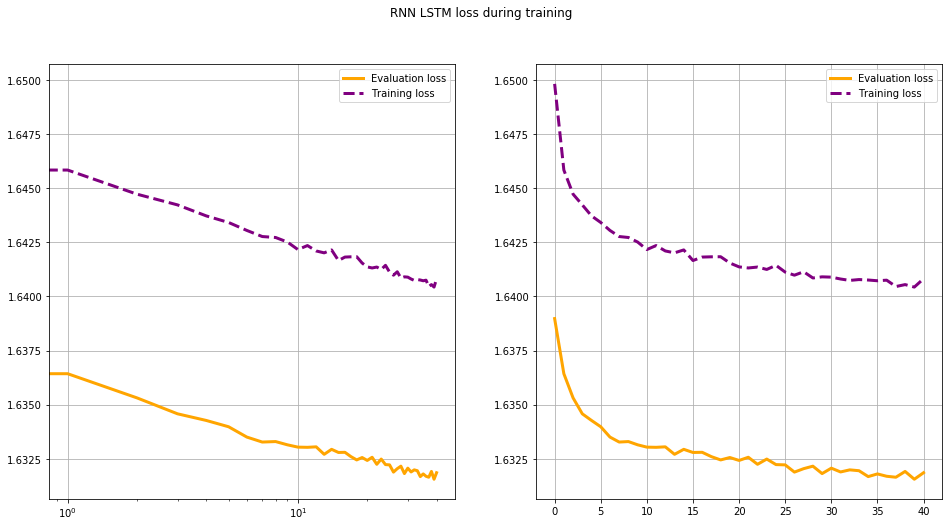

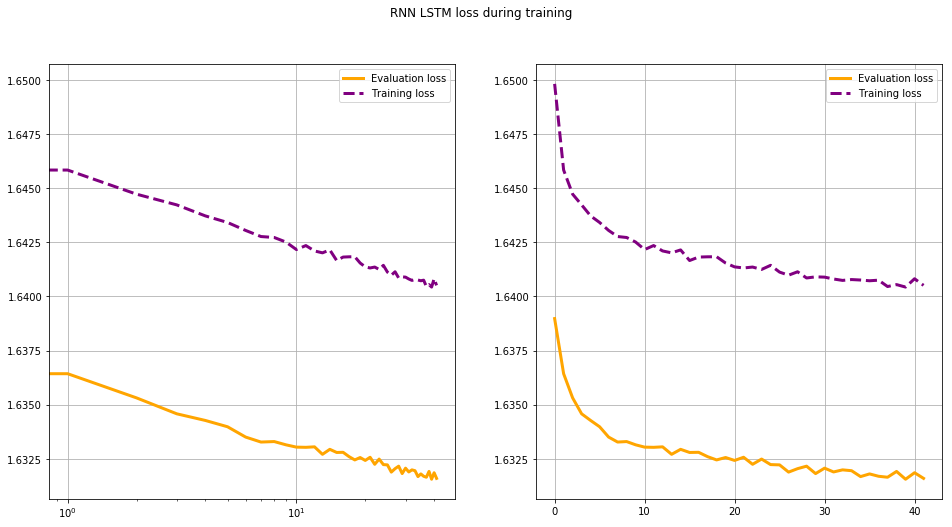

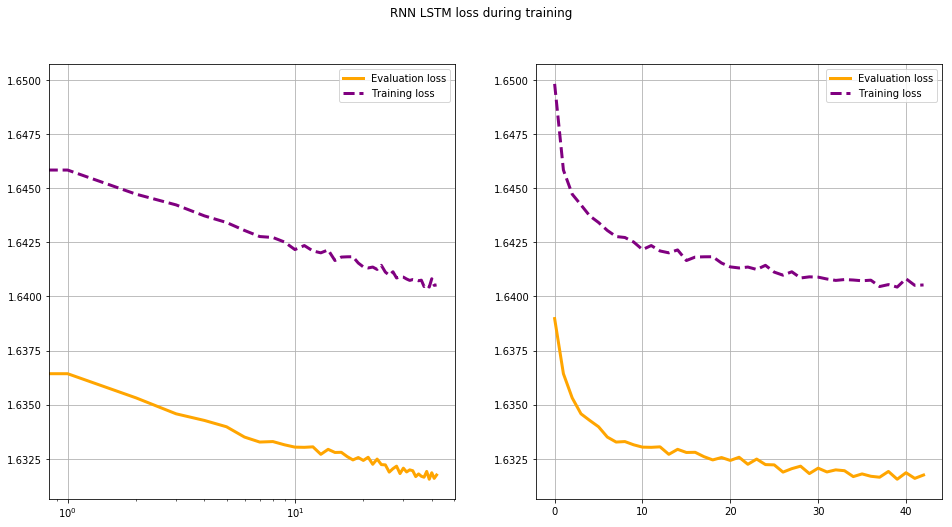

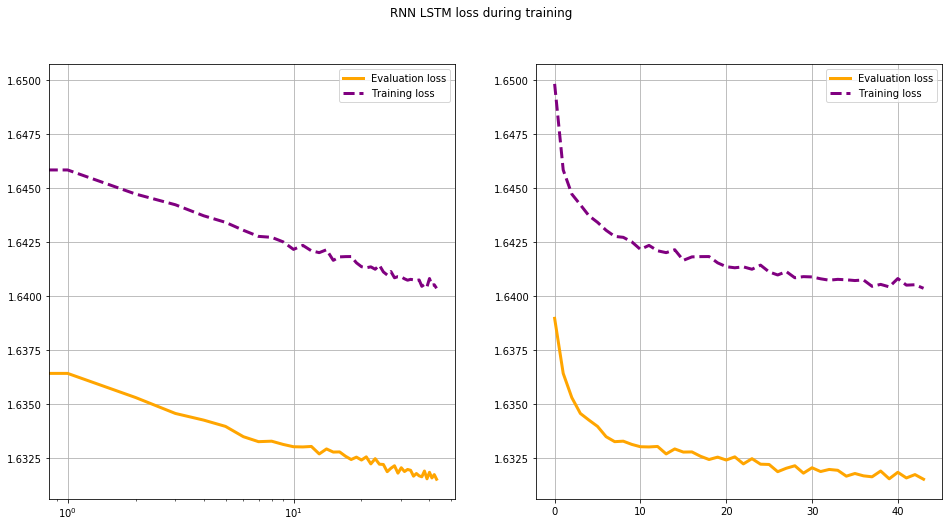

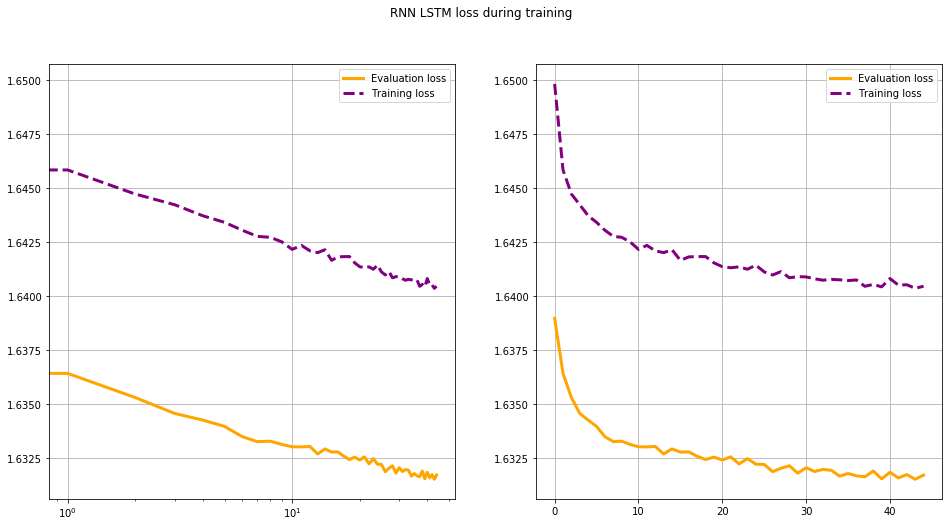

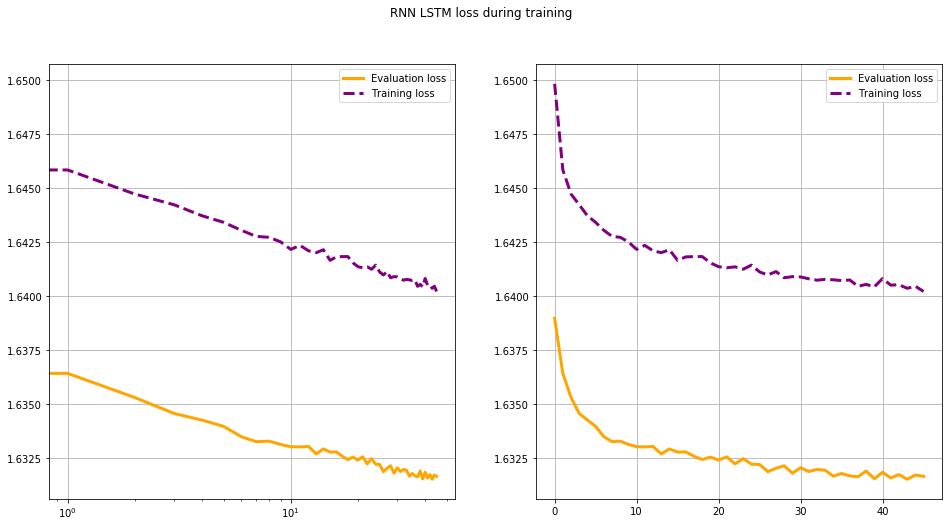

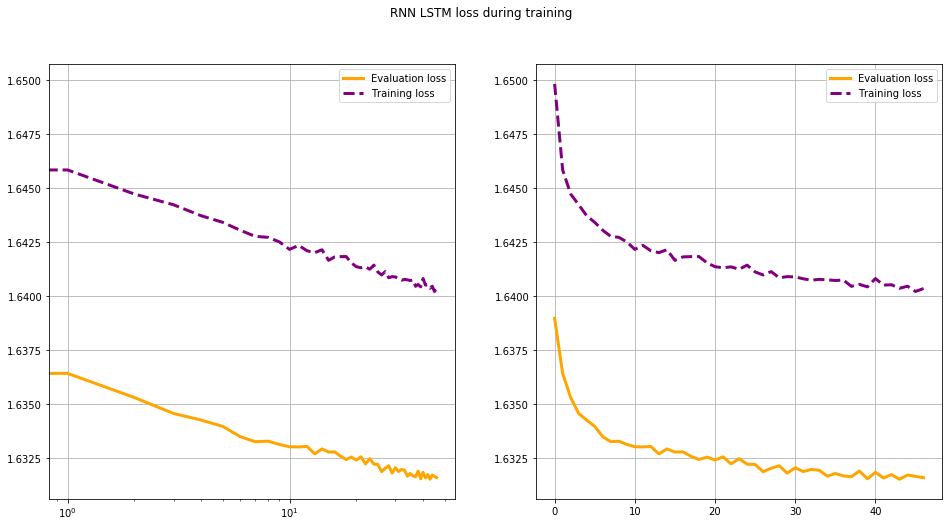

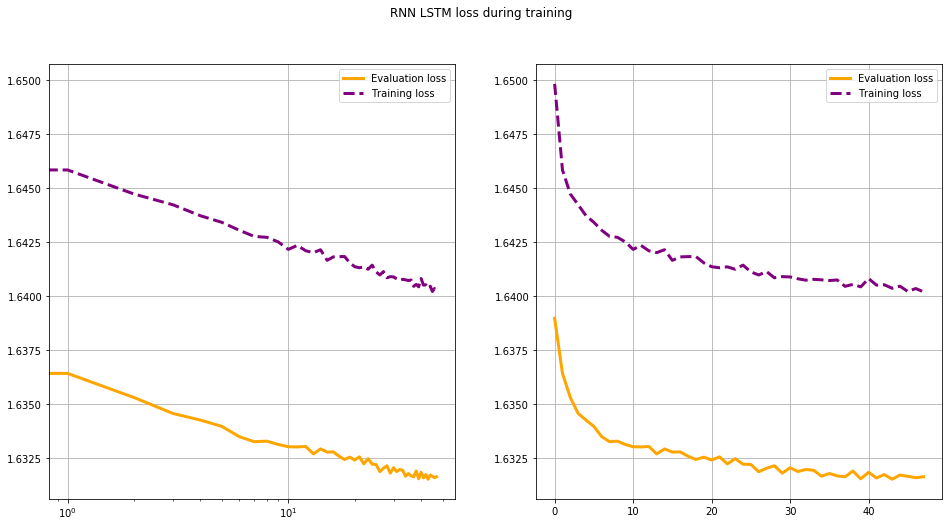

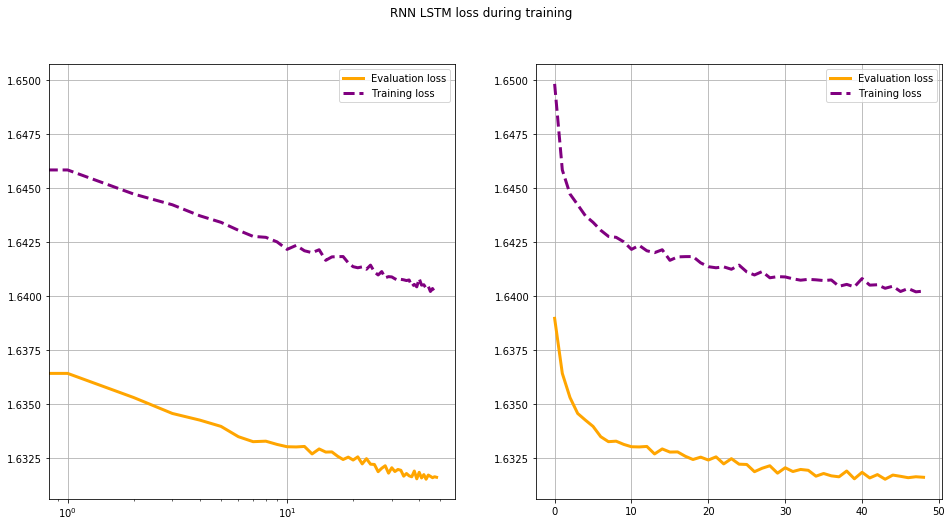

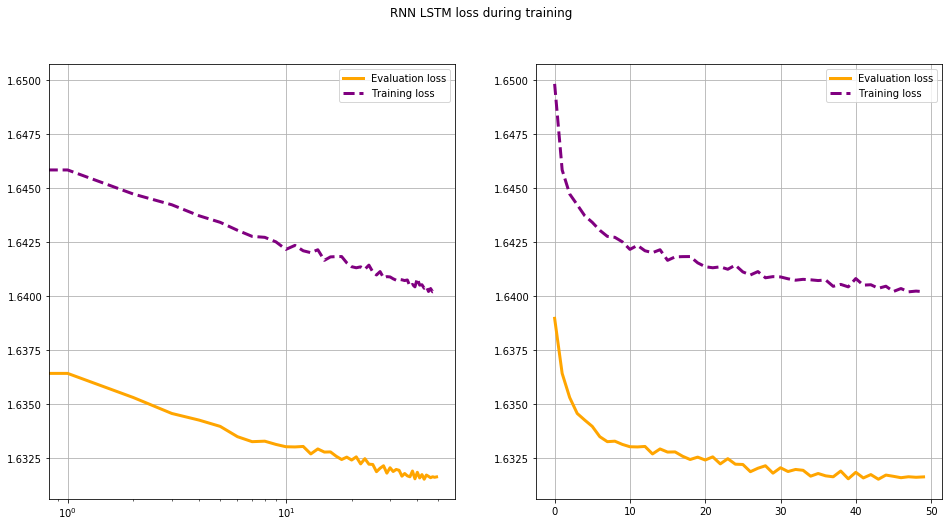

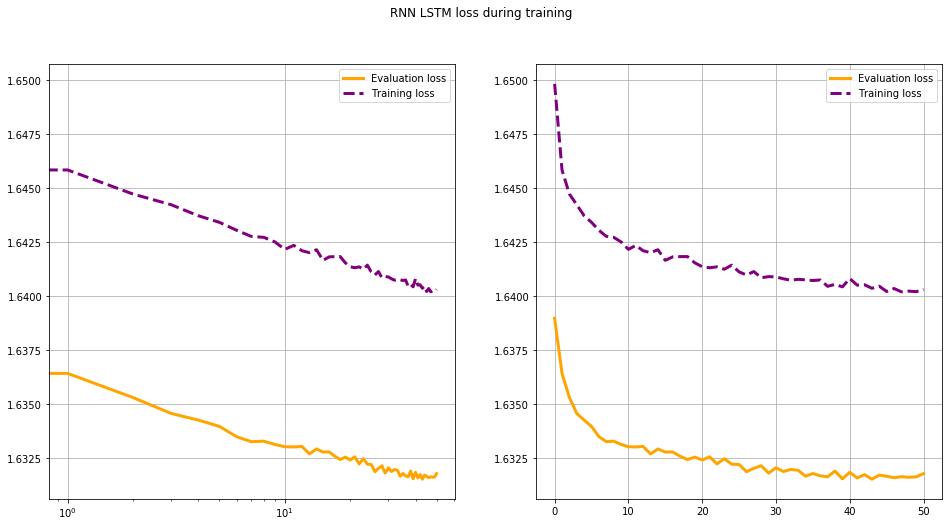

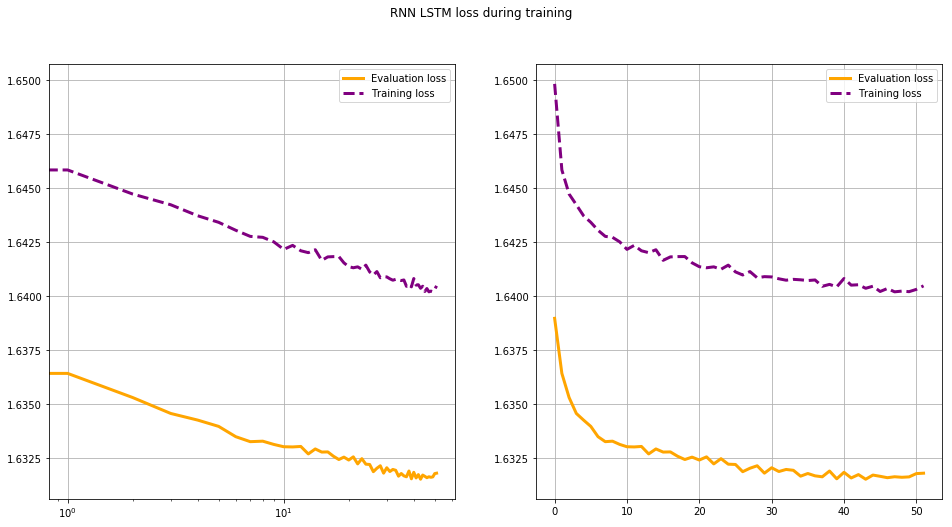

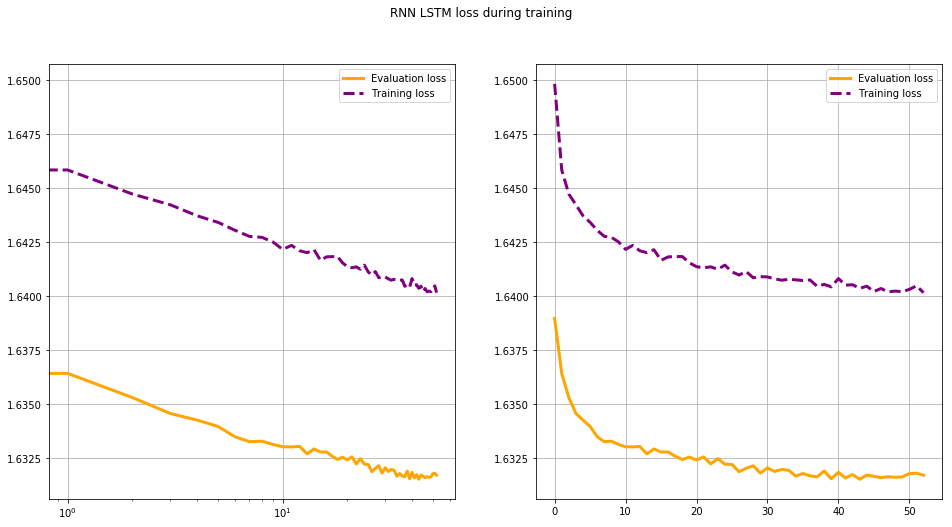

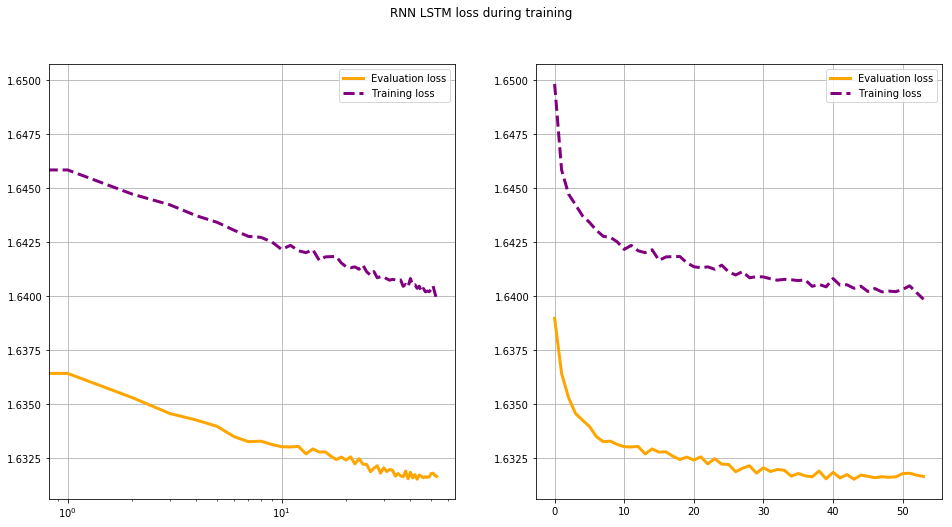

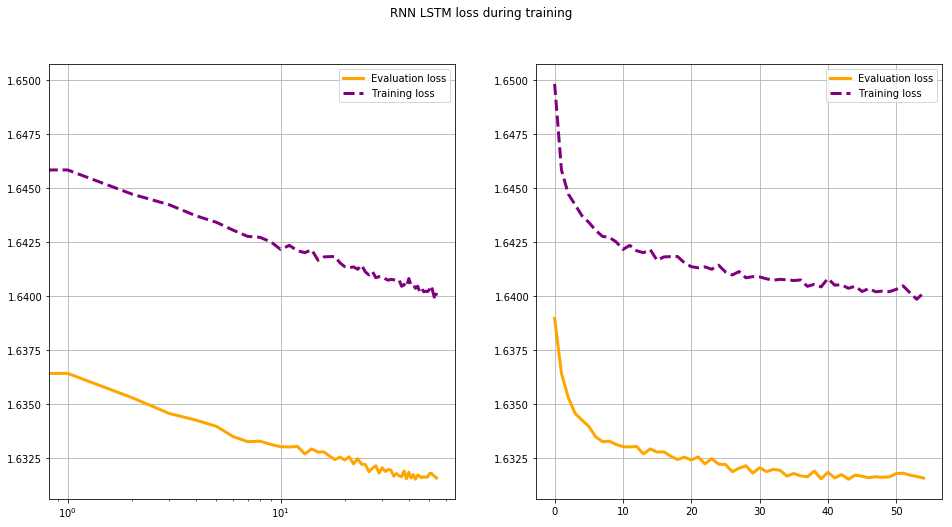

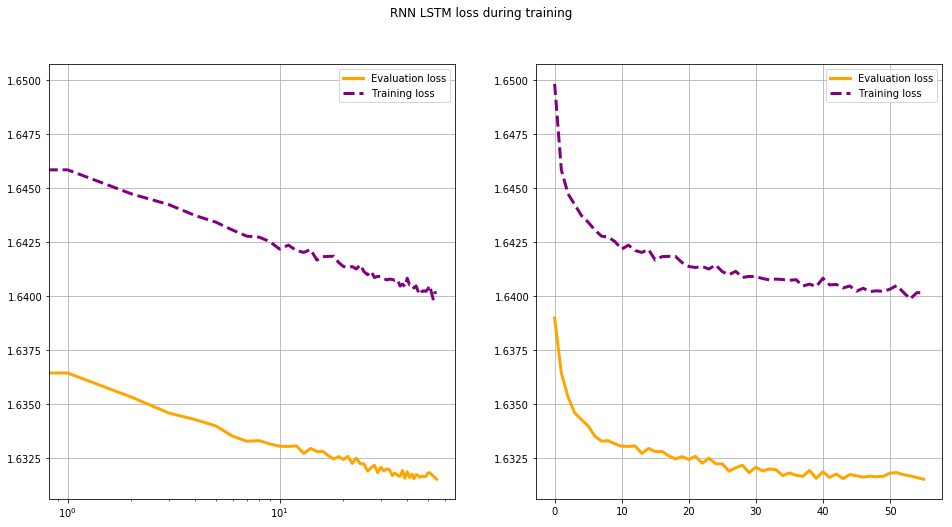

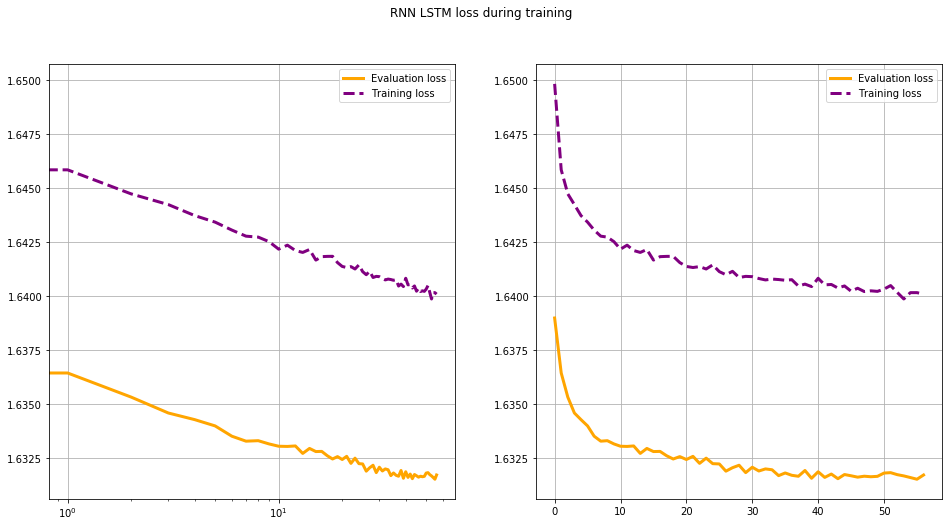

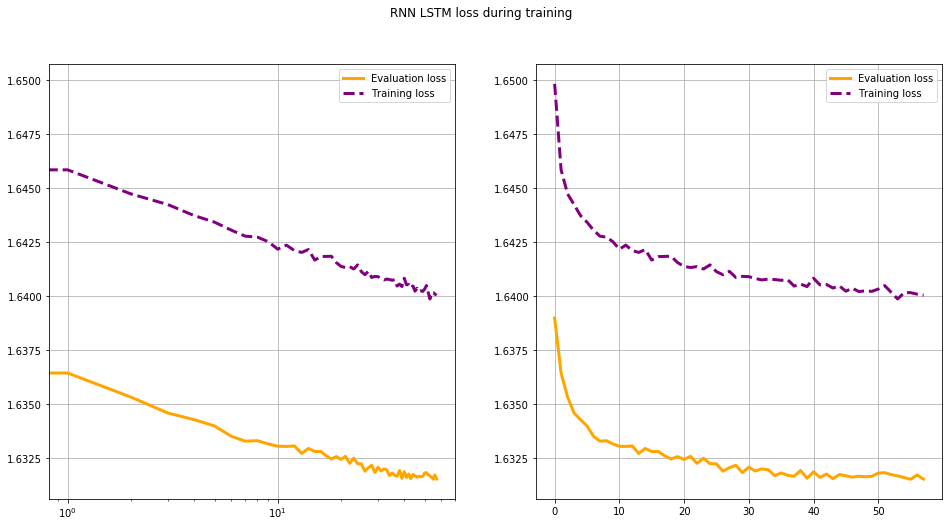

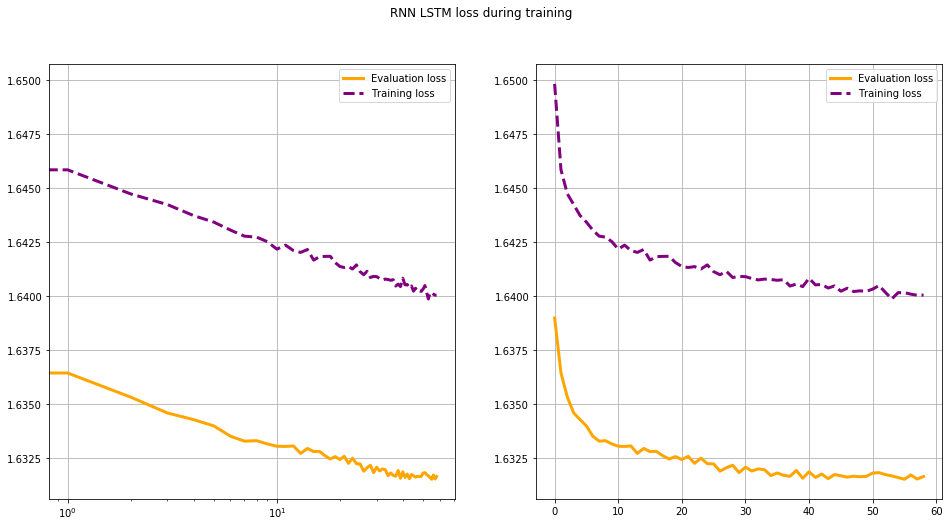

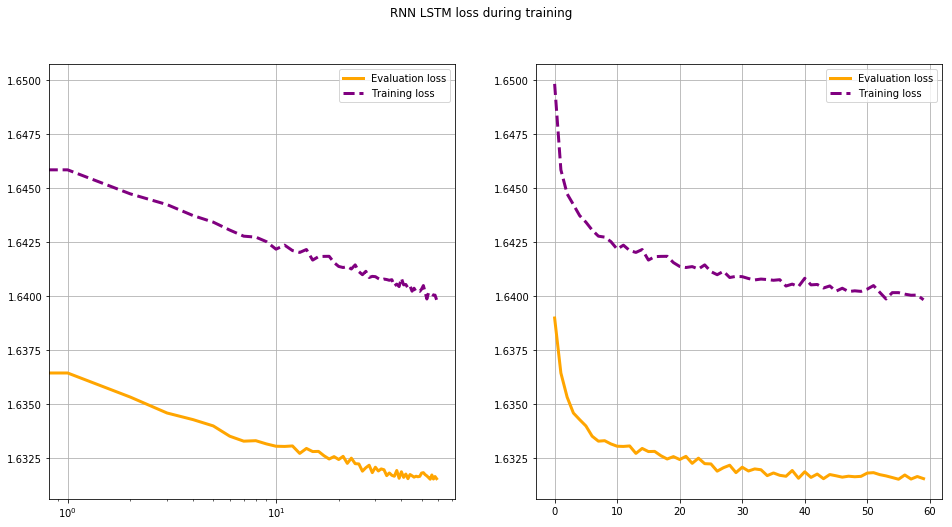

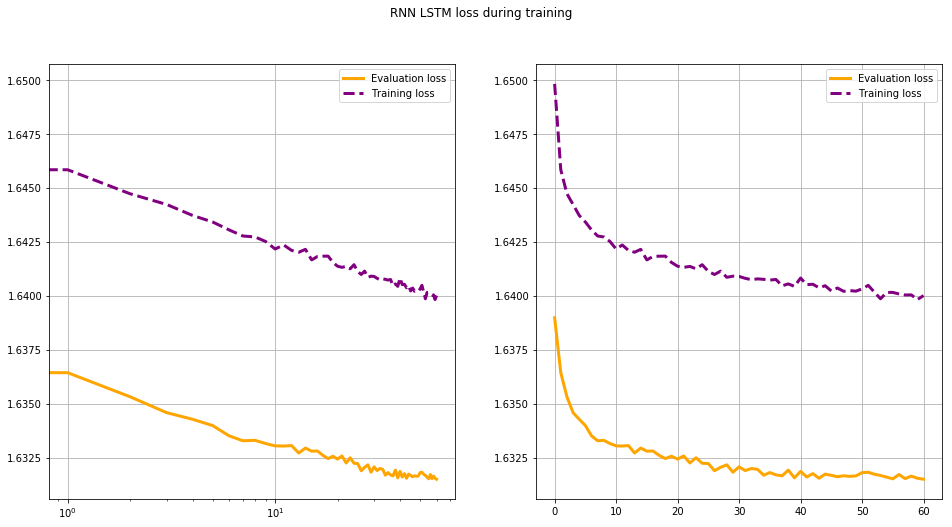

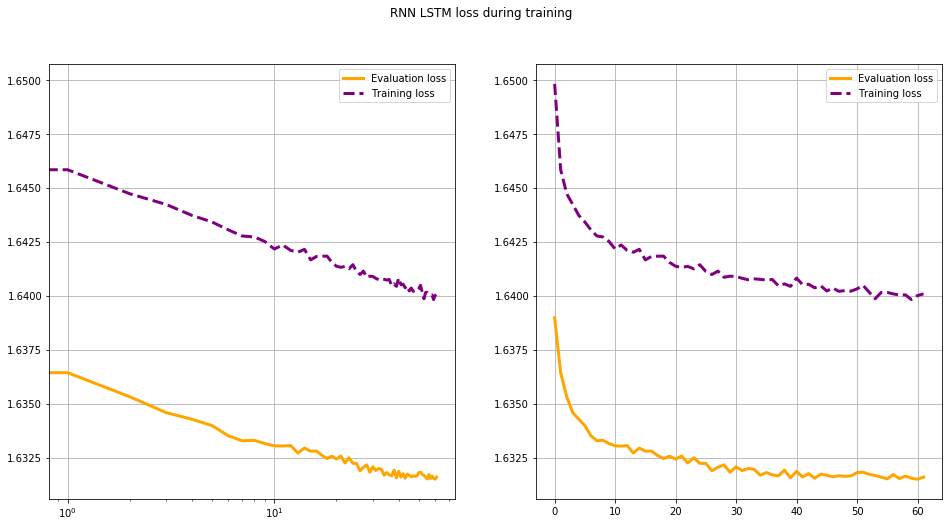

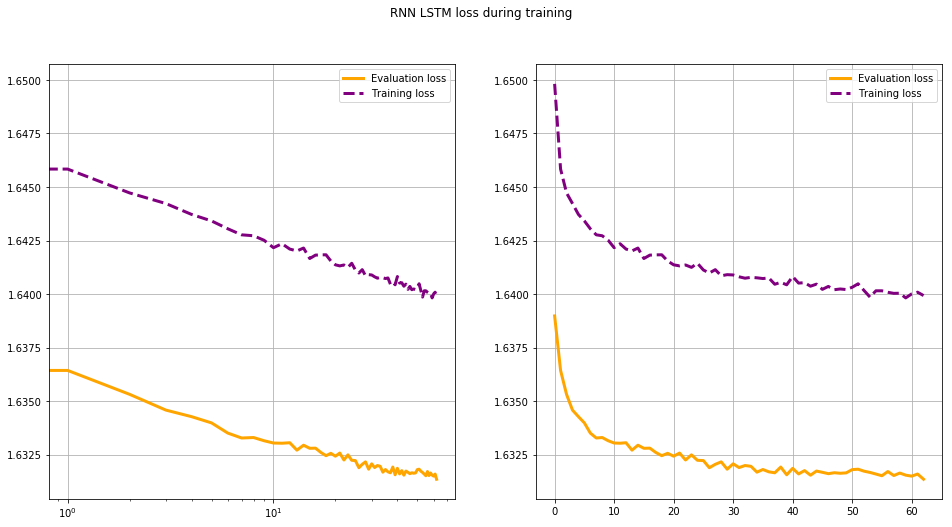

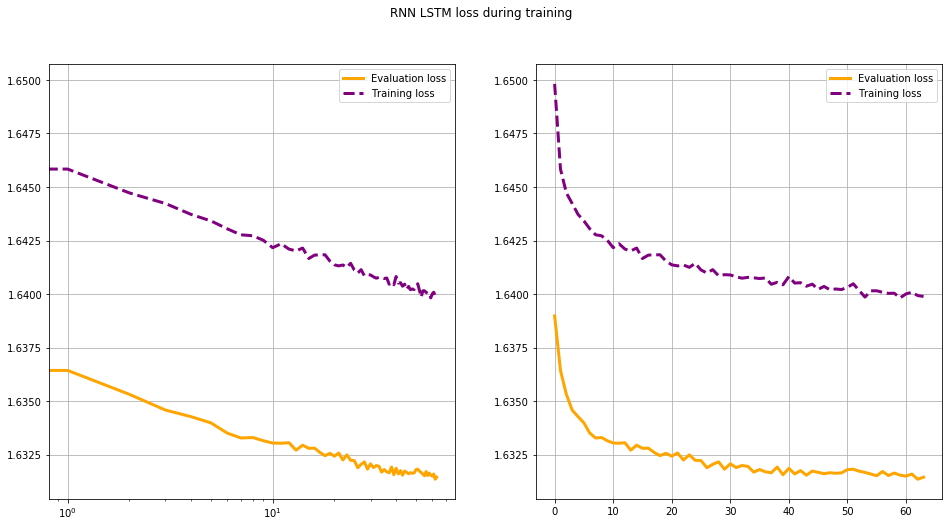

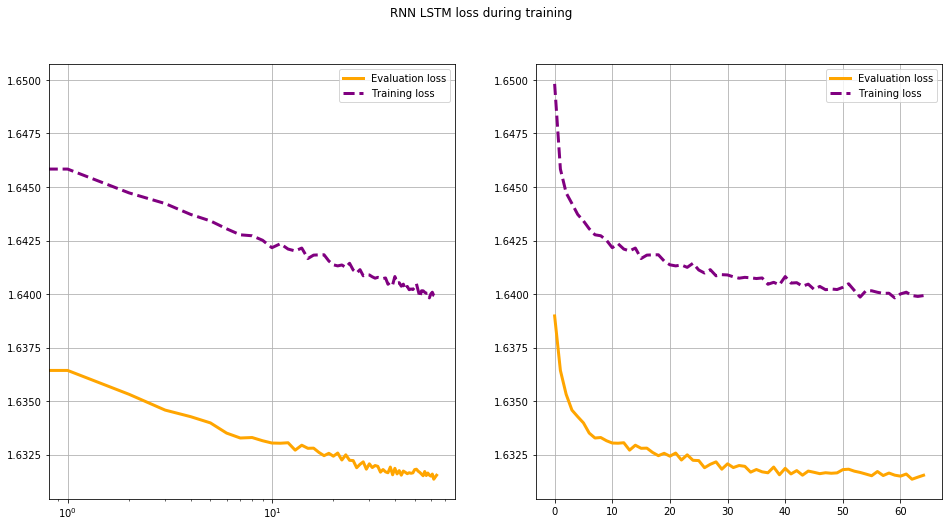

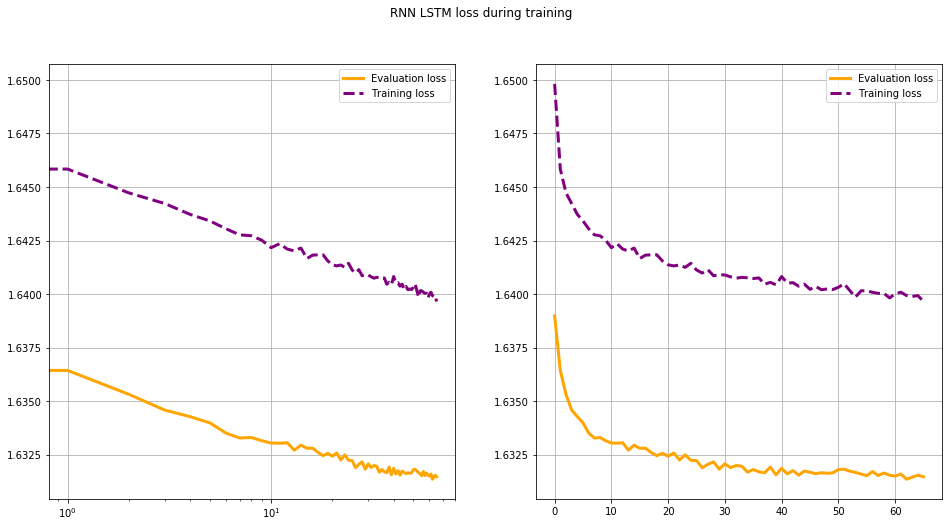

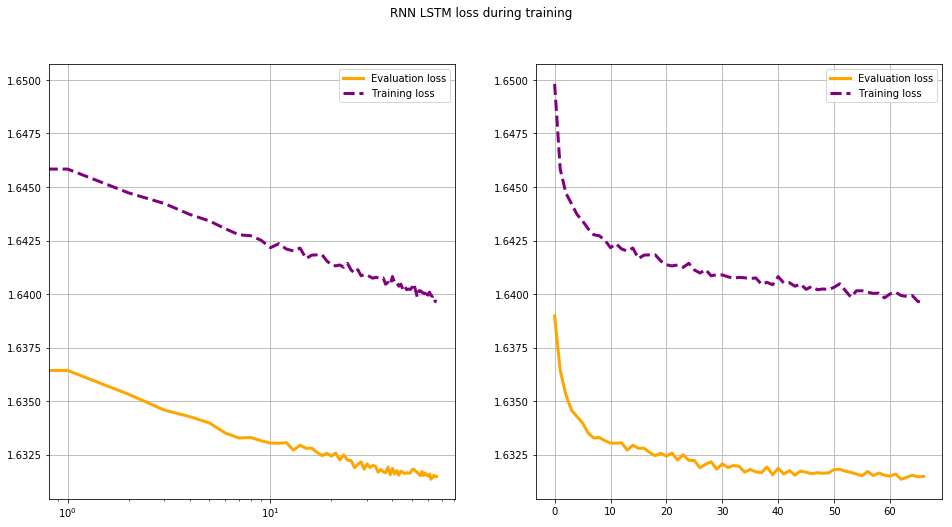

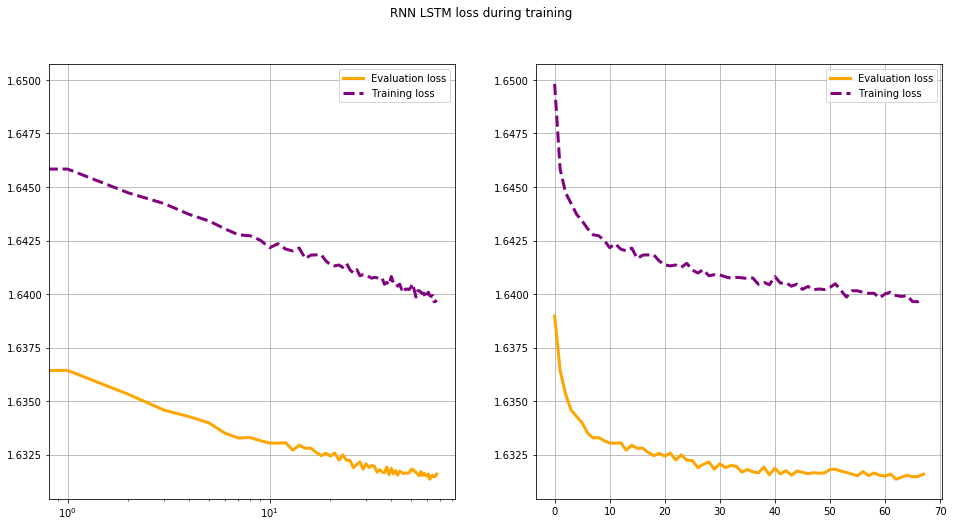

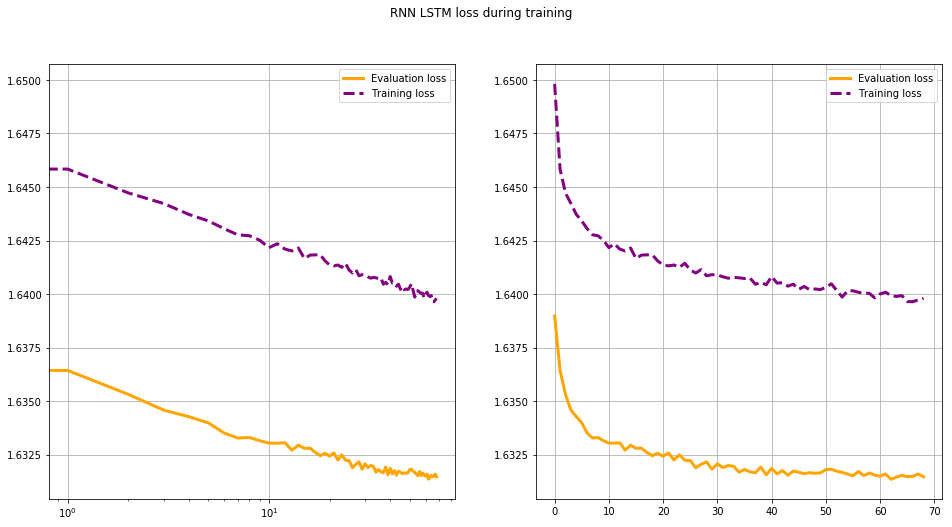

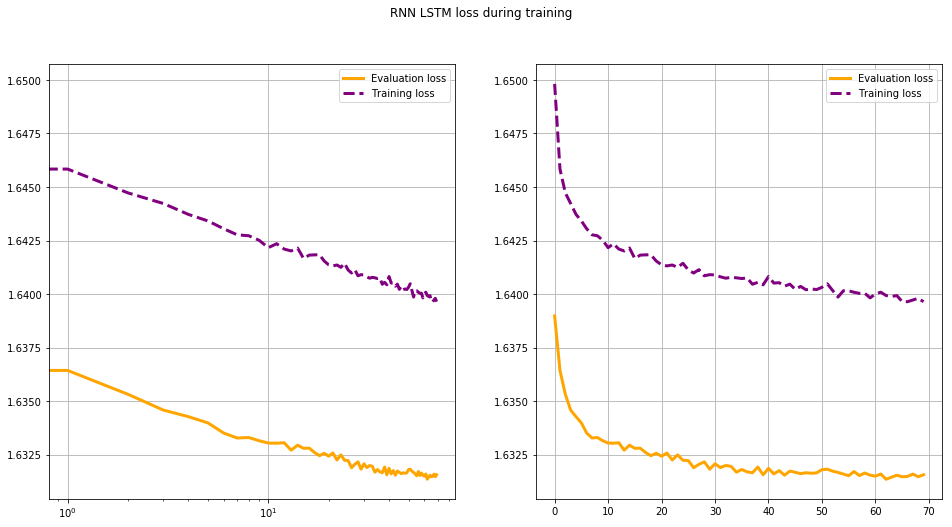

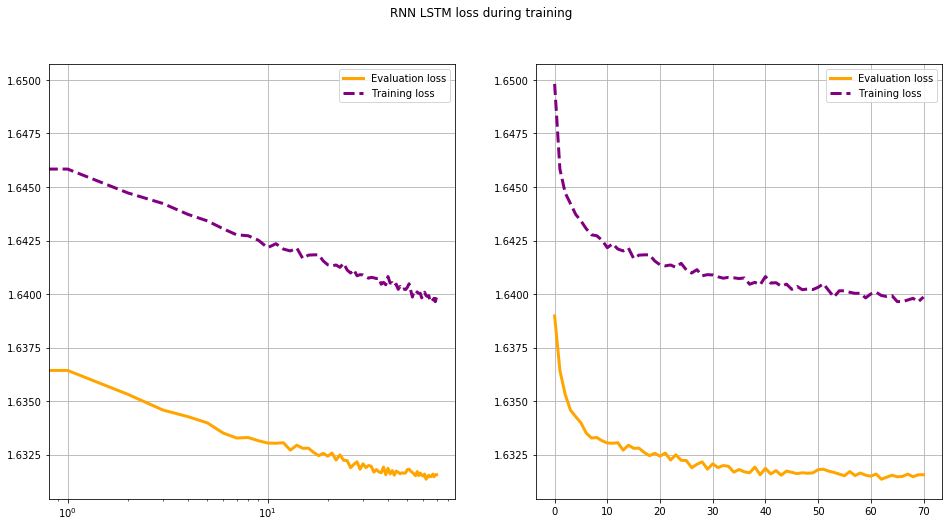

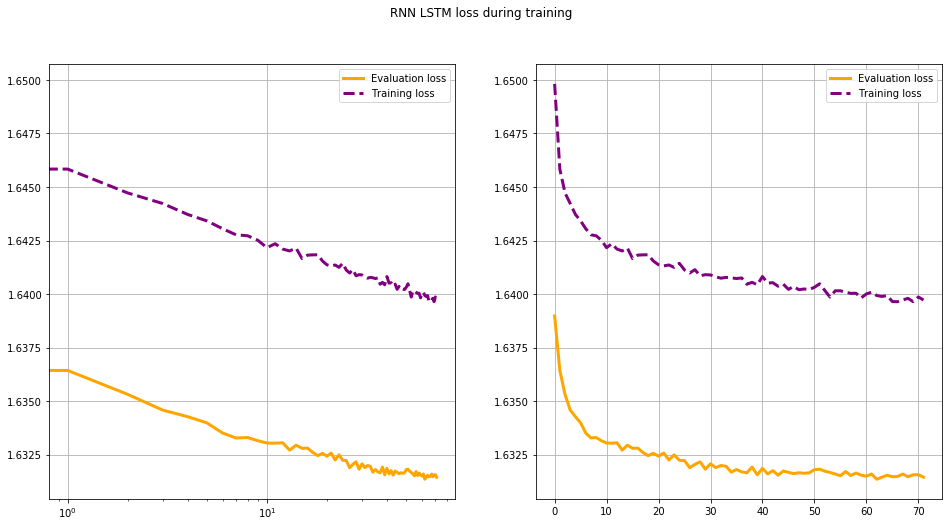

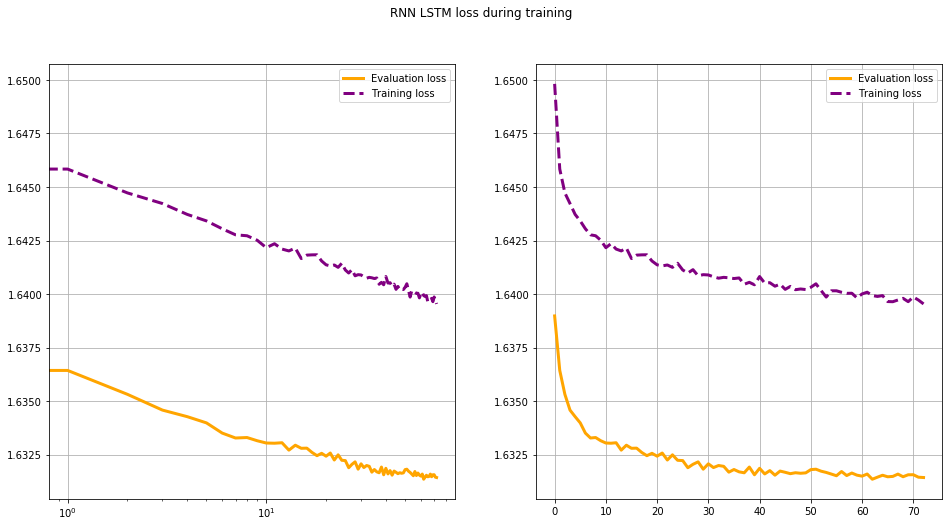

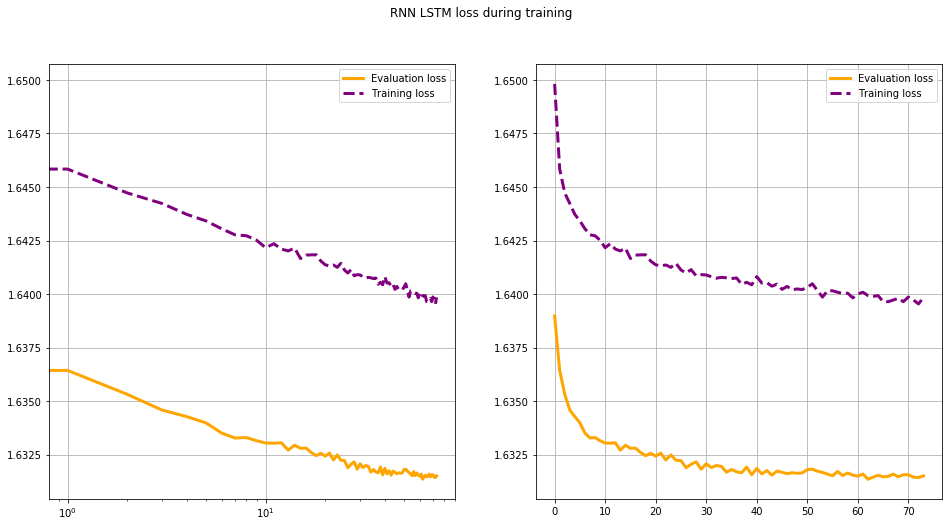

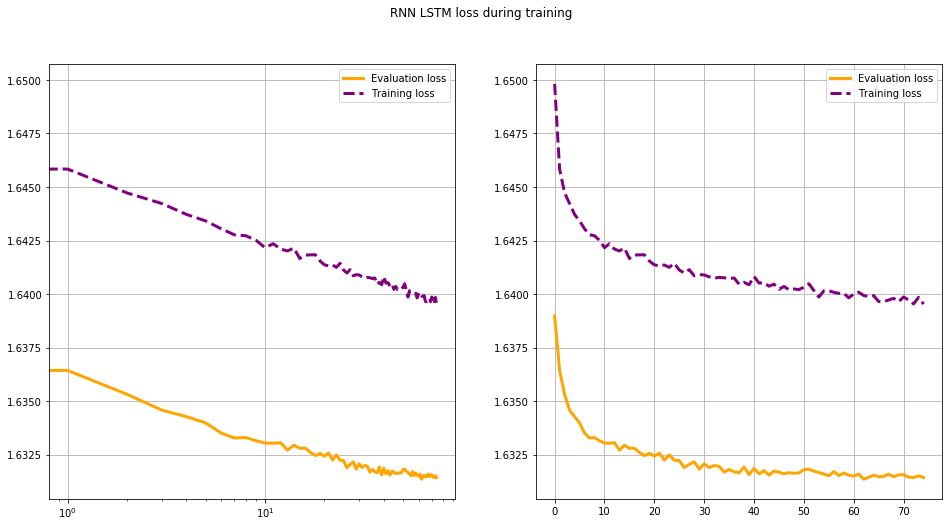

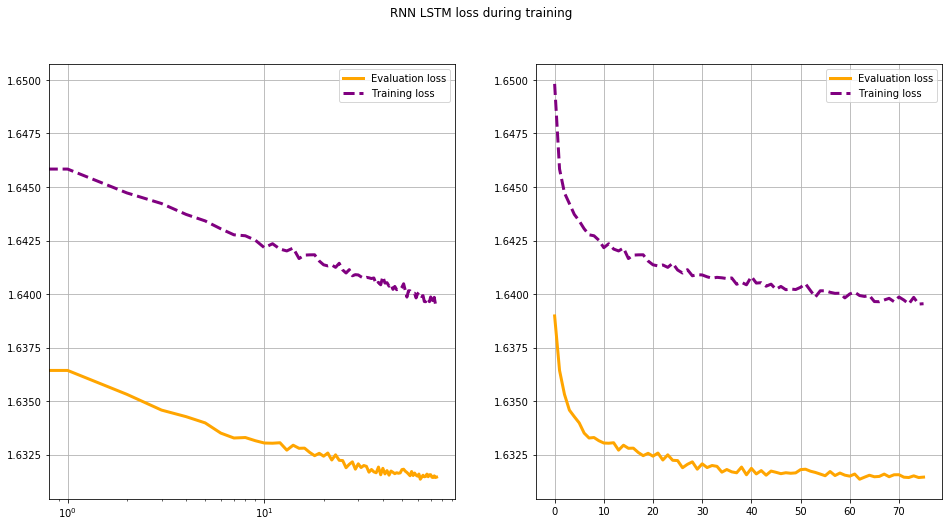

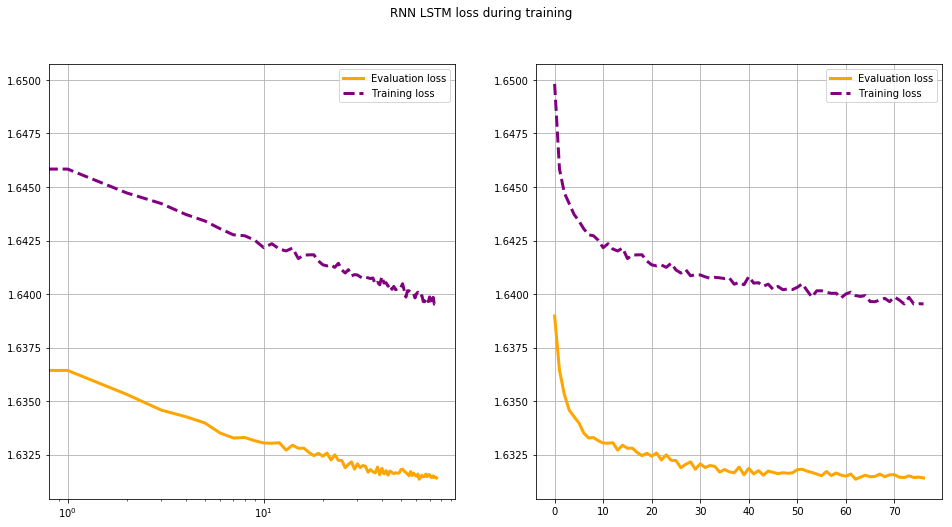

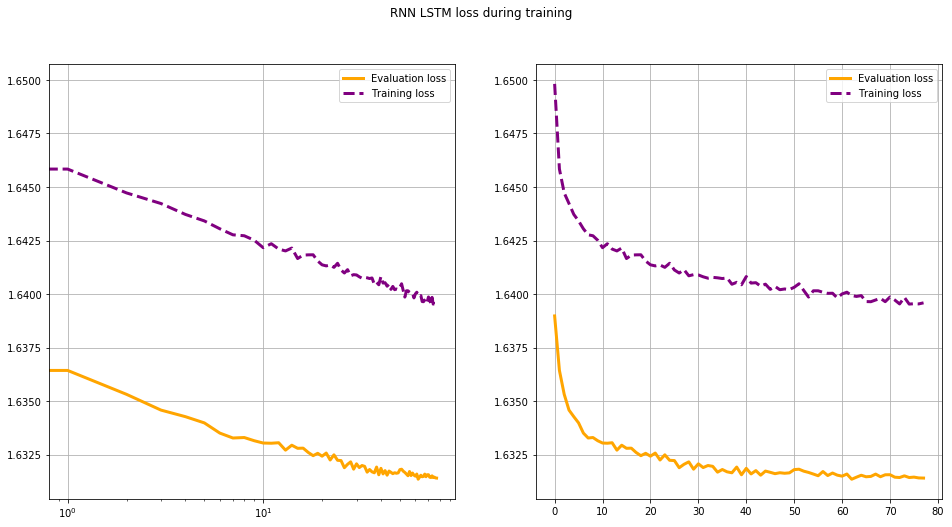

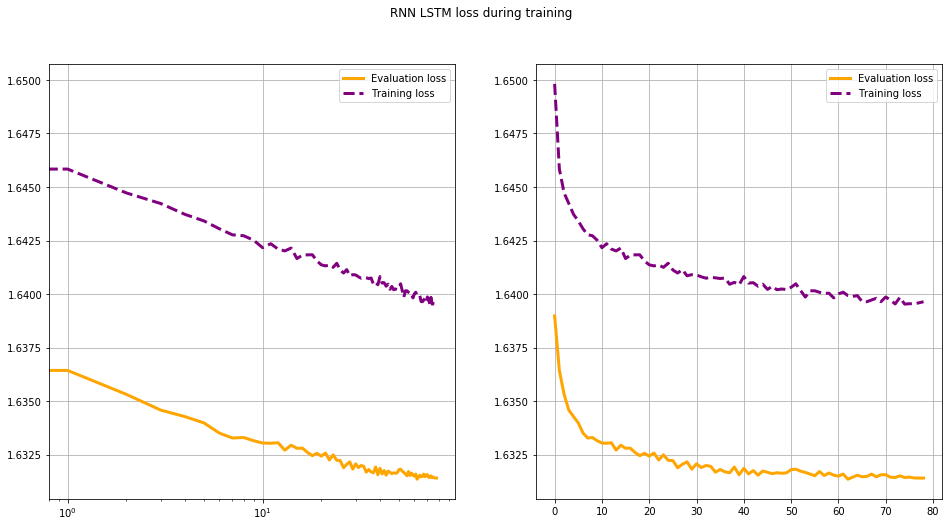

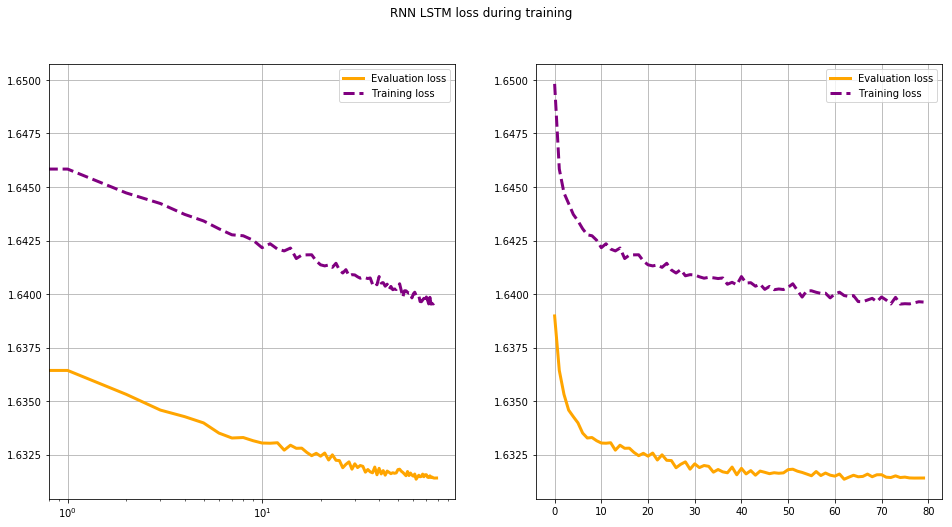

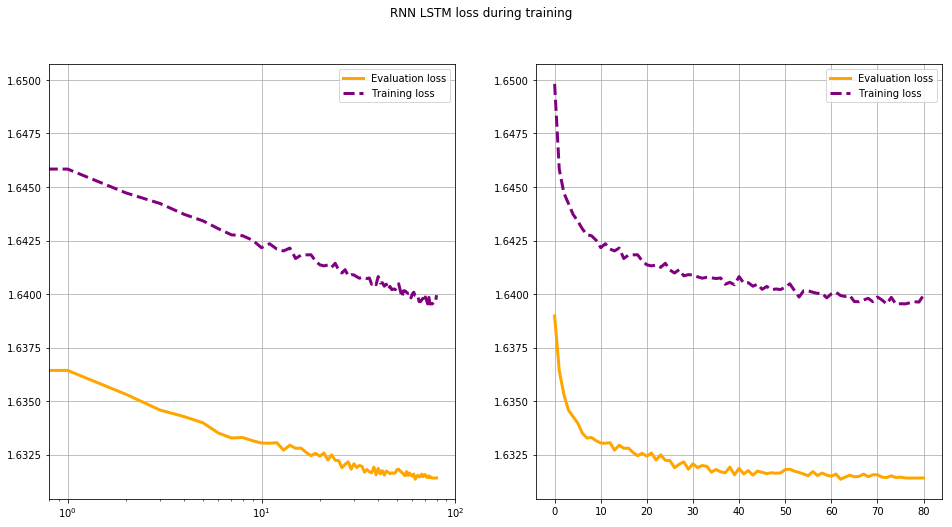

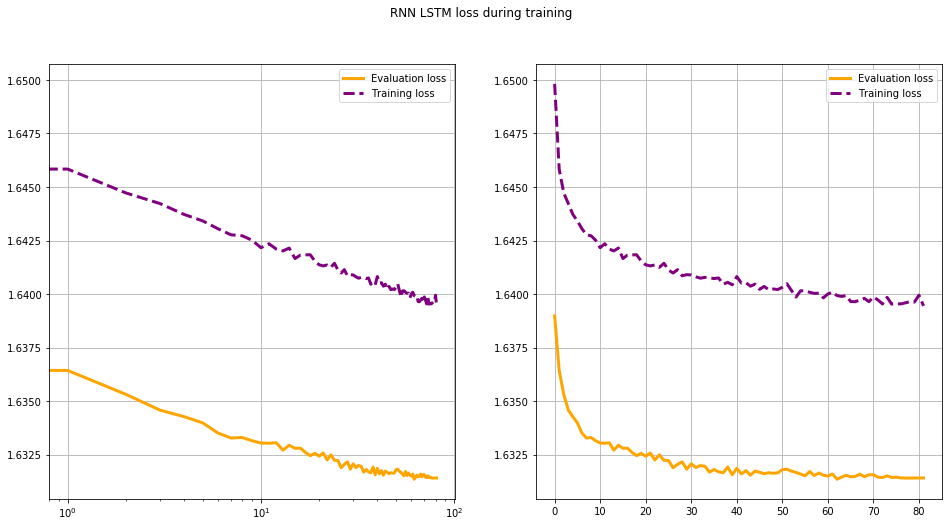

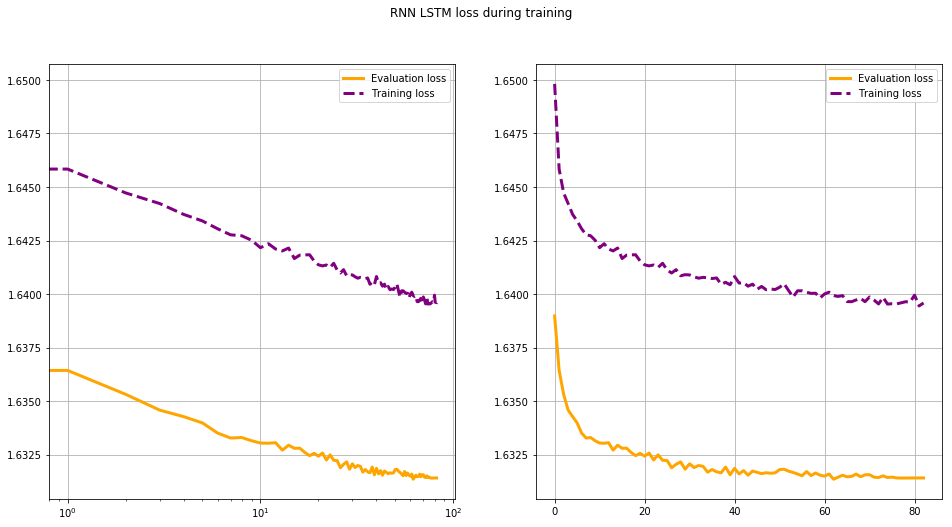

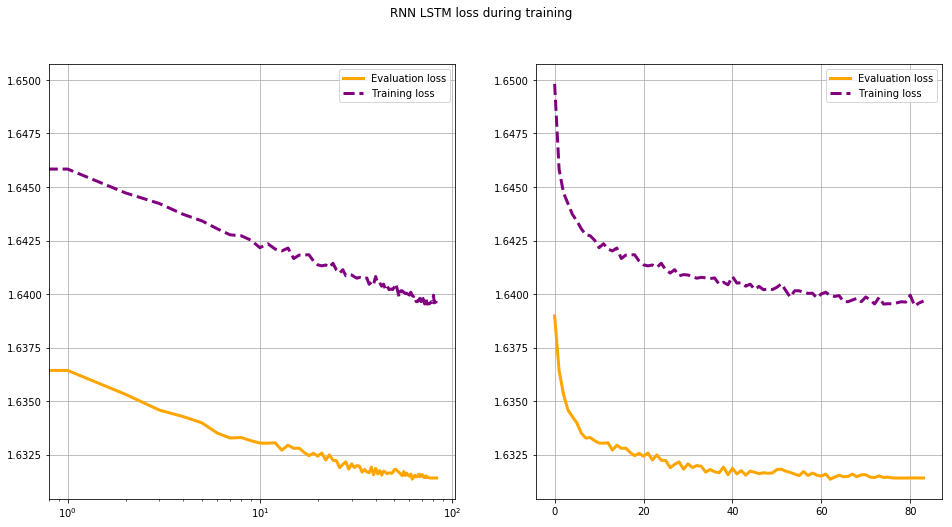

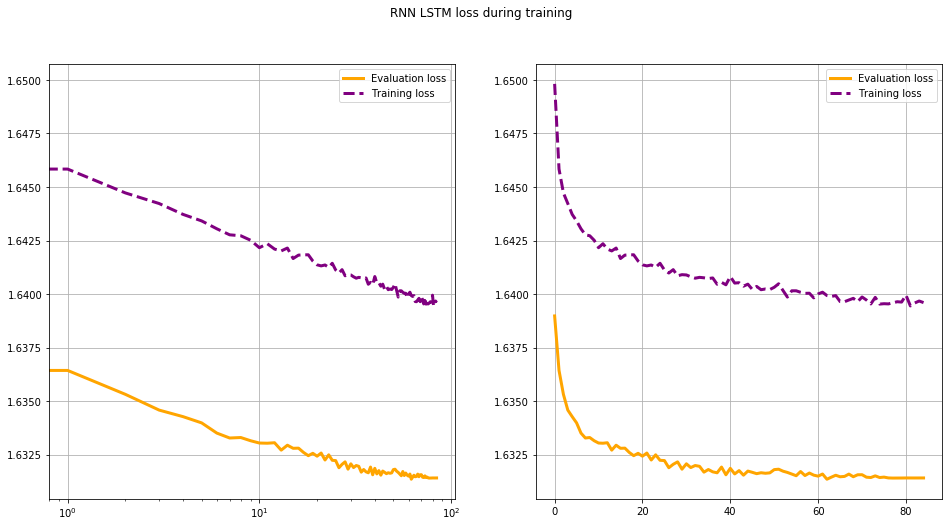

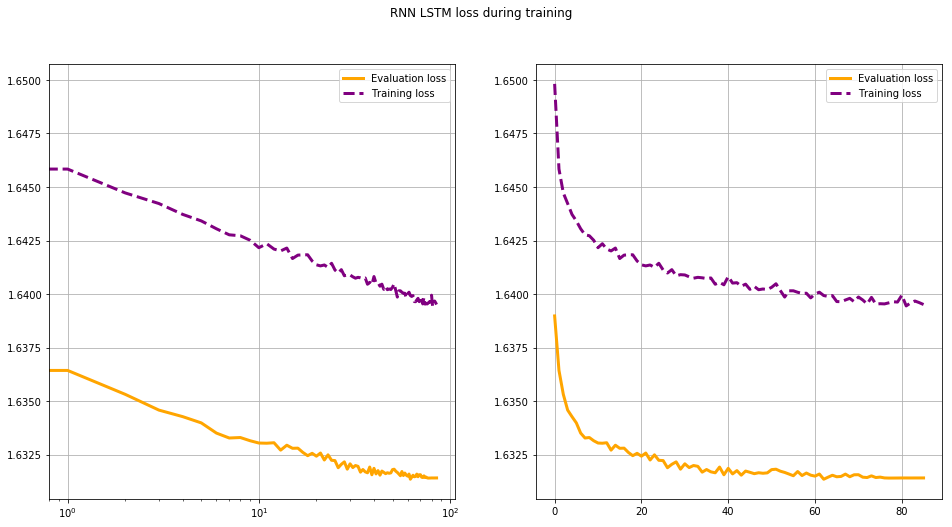

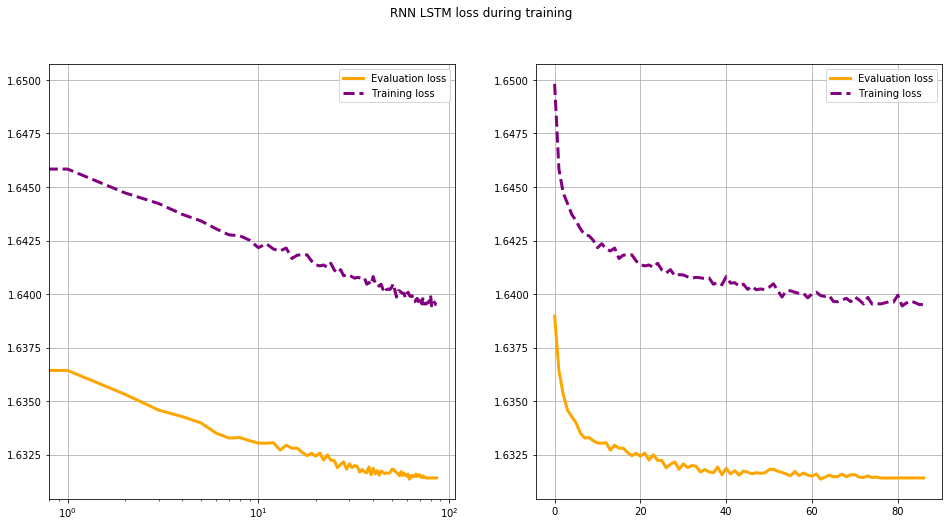

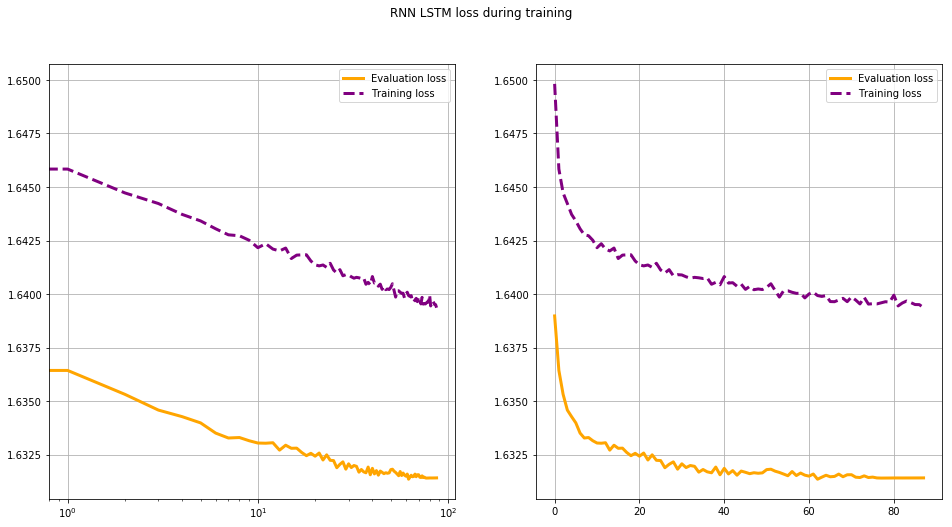

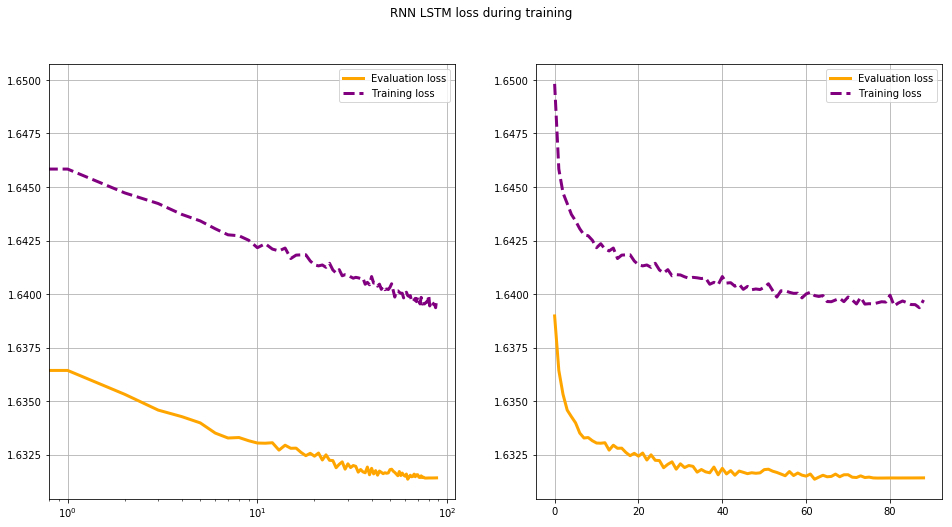

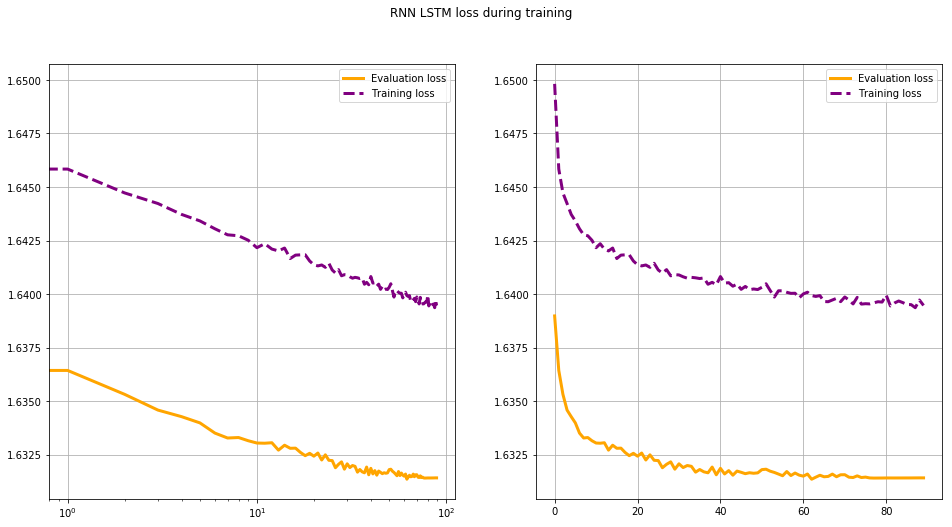

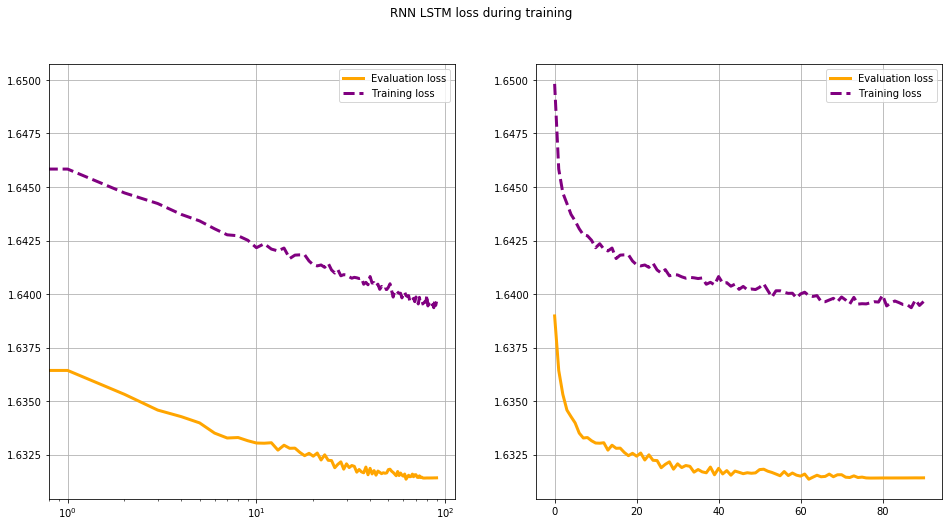

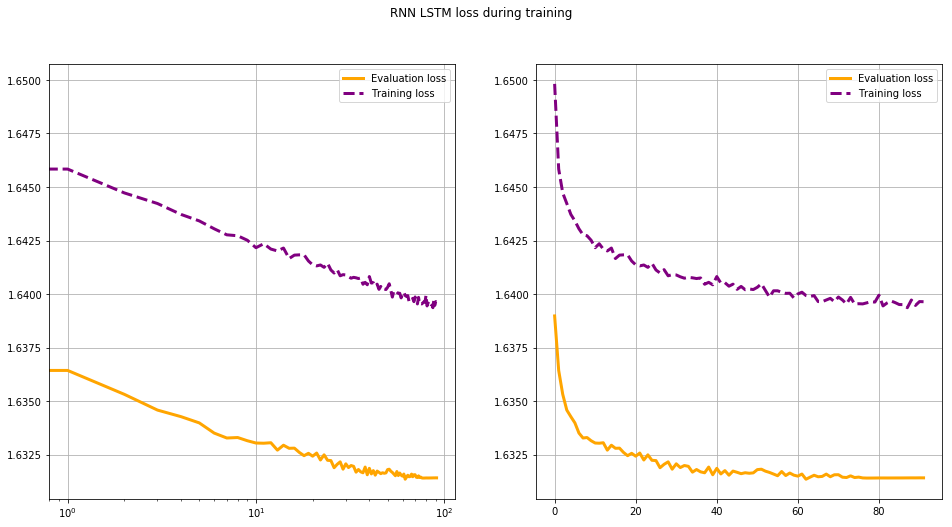

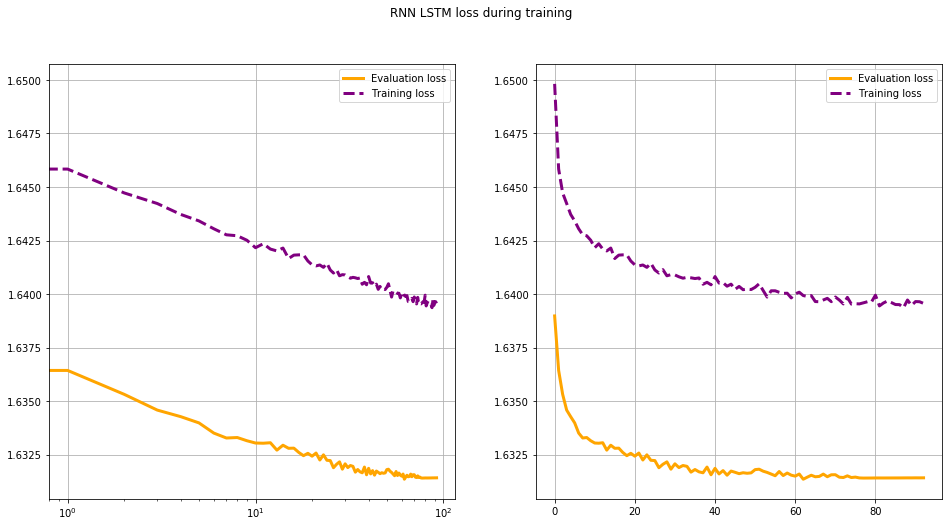

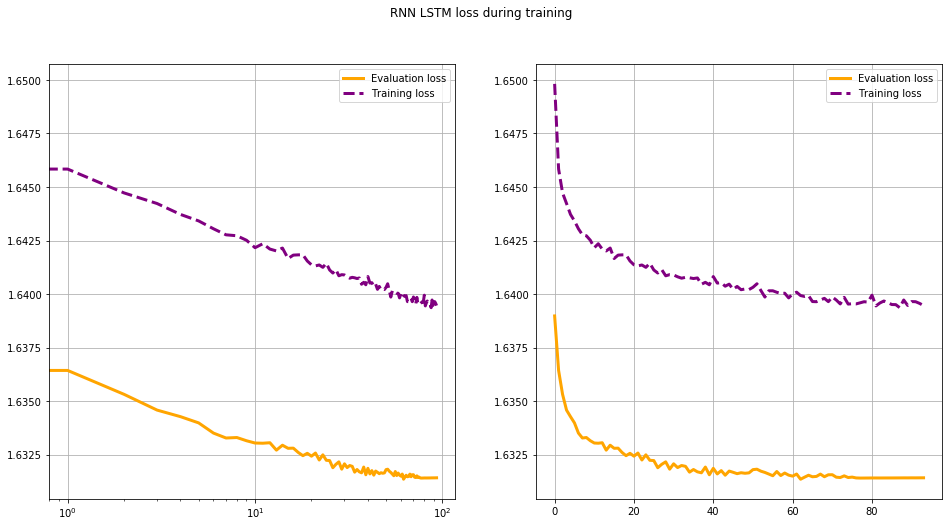

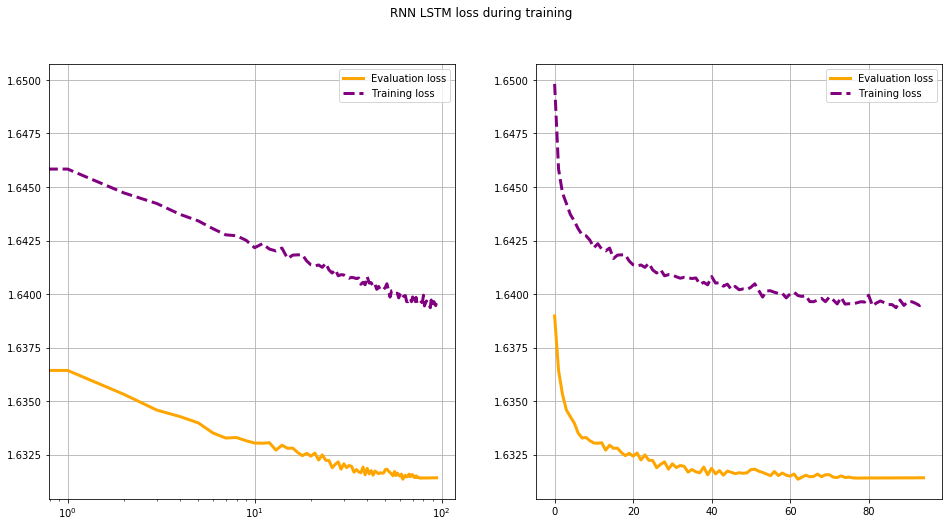

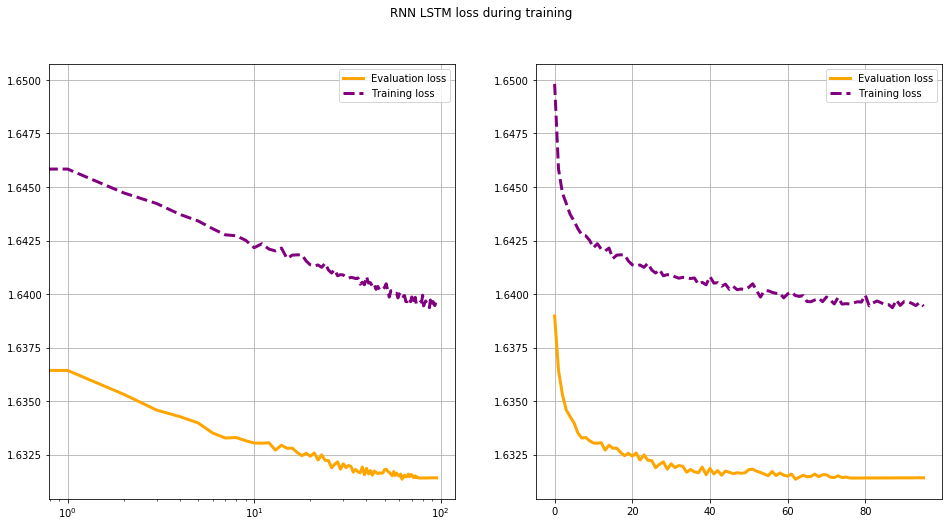

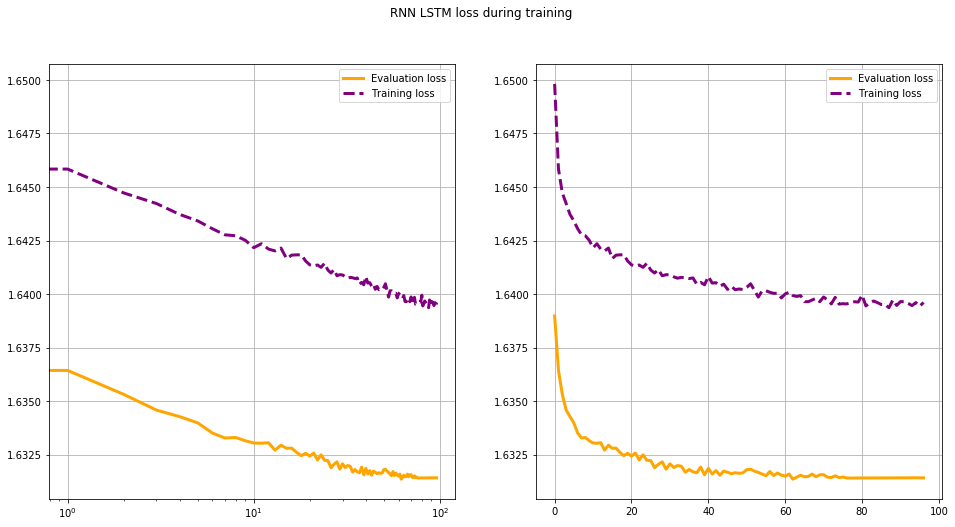

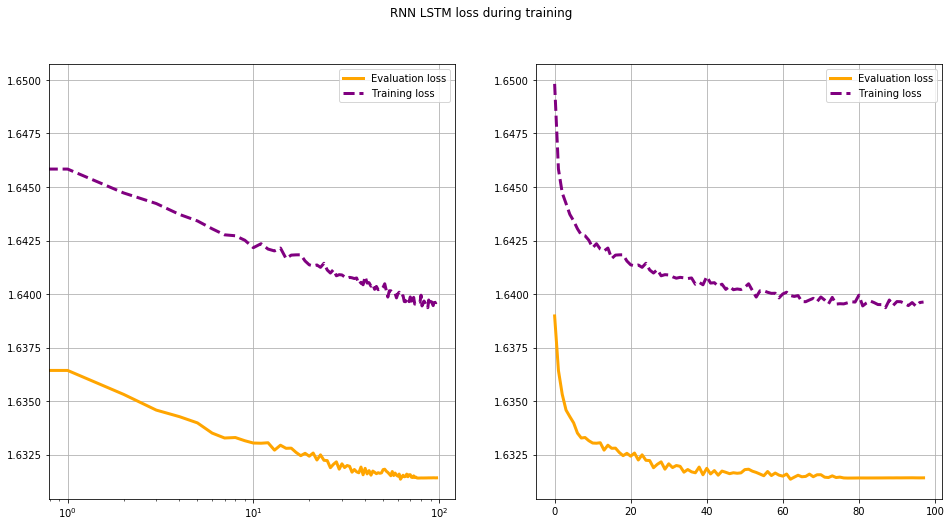

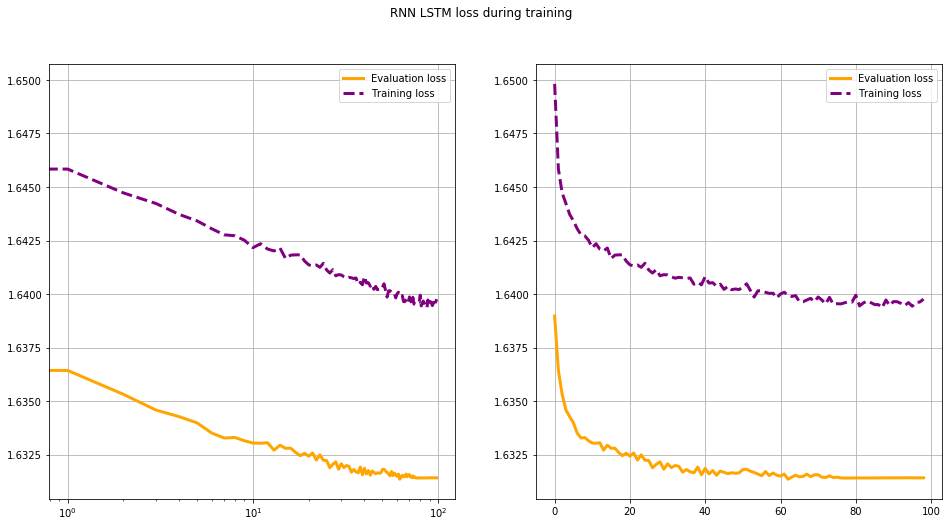

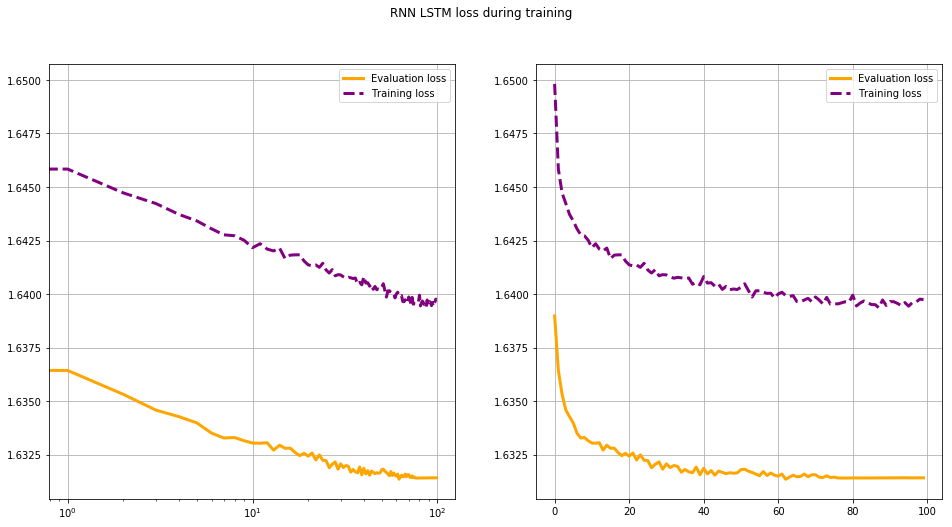

In [17]:
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Instantiate a loss function.
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)  # not sure this should be from logits

# Prepare the training dataset.
batch_size = batch_size

# Iterate over epochs.
epochs = epochs

# array for losses
losses = None
eval_losses = np.array([])

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    learning_rate = learning_rate_scheduler(epoch, fixed_at_epoch=fixed_at_epoch, init_rate=1e-3)
    dropout_rate = dropout_rate_scheduler(epoch, zero_at_epoch=fixed_at_epoch, init_rate=init_dropout_rate)
    
    optimizer.learning_rate = learning_rate
    model.get_layer(name='c_init_dropout').rate = dropout_rate
    model.get_layer(name='h_init_dropout').rate = dropout_rate
    model.get_layer(name='lstm_out_dropout').rate = dropout_rate
    model.get_layer(name='lstm')._recurrent_dropout = dropout_rate
    model.get_layer(name='lstm')._dropout = dropout_rate
    
    print('learning_rate: {0} \n lstm_out dropout_rate: {1}'.format(optimizer.learning_rate.numpy(), model.get_layer(name='lstm_out_dropout').rate))
    
    # Iterate over the batches of the dataset.
    batch_losses = np.array([])
    for step, (data_batch_train, 
               prep_batch_train,
               time_batch_train, 
               probs_batch_train,
               mask_train) in enumerate(train_dataset):
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            p_out_full = model(inputs=(tf.expand_dims(data_batch_train, axis=-1),
                                       prep_batch_train,
                                       mask_train,
                                      ),
                               training=True,
                              )
            time_batch_train = tf.expand_dims(time_batch_train, axis=-1)
            time_gather = tf.gather(p_out_full, 
                                    time_batch_train,
                                    axis=1, 
                                    batch_dims=1,
                                    name='time_gather')
            time_output = tf.squeeze(time_gather, axis=-2,)
        
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(probs_batch_train, time_output)
            
            # Record loss value for minibatch
            batch_losses = np.append(batch_losses, loss_value)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Record the losses
    batch_losses = np.expand_dims(batch_losses, axis=0)
    if epoch == 0:
        losses = batch_losses
    else:
        losses = np.append(losses, batch_losses, axis=0)

    # validation
    print('before extract w enumerate')
    for step, (data, prep, time, labels, mask) in enumerate(test_dataset):
        val_data = data
        val_prep = prep
        val_time = time
        val_labels = labels
        val_mask = mask

    p_out_full = model(inputs=(tf.expand_dims(val_data, axis=-1),
                                       val_prep,
                                       val_mask,
                                      ),
                        training=False,
                              )
    
    time_batch_train = tf.expand_dims(val_time, axis=-1)
    time_gather = tf.gather(p_out_full, 
                            time_batch_train,
                            axis=1, 
                            batch_dims=1,
                            name='time_gather')
    time_output = tf.squeeze(time_gather, axis=-2,)
    
    eval_loss = loss_fn(val_labels, time_output)
    eval_losses = np.append(eval_losses, eval_loss)
    print(f'Evaluation loss: {eval_loss}')
    
    # plot results 
    _x = np.arange(epoch+1)
    _maxes = losses.max(axis=1)
    _mins = losses.min(axis=1)
    _avgs = losses.mean(axis=1)
    _x = np.arange(epoch+1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ax1.grid()
#     lw = 0
#     ax1.plot(_x, eval_losses, color='orange', marker='o', label='Evaluation loss', lw=lw)
#     ax1.fill_between(_x, _mins, _maxes, alpha=0.15, color='purple')
#     ax1.plot(_x, _avgs, color='purple', marker='o', label='Training loss', lw=lw)
    lw = 3
    ax1.plot(_x, eval_losses, color='orange', marker=None, label='Evaluation loss', ls='-', lw=lw)
    ax1.plot(_x, _avgs, color='purple', marker=None, label='Training loss', ls='--', lw=lw)
    ax1.set_xscale('log')
    ax1.legend()
    
    ax2.grid()
#     ax2.plot(_x, eval_losses, color='orange', marker='o', label='Evaluation loss', lw=lw)
#     ax2.fill_between(_x, _mins, _maxes, alpha=0.15, color='purple')
#     ax2.plot(_x, _avgs, color='purple', marker='o', label='Training loss', lw=lw)
    ax2.plot(_x, eval_losses, color='orange', marker=None, label='Evaluation loss', ls='-', lw=lw)
    ax2.plot(_x, _avgs, color='purple', marker=None, label='Training loss', ls='--', lw=lw)
    
    ax2.set_xscale('linear')
    ax2.legend()
    
    fig.suptitle('RNN LSTM loss during training')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

# Evaluate model

# longest times

In [43]:
for step, (data, prep, time, labels, mask) in enumerate(test_dataset):
    eval_data = data.numpy()
    eval_prep = prep.numpy()
    eval_time = time.numpy()
    eval_labels = labels.numpy()
    eval_mask = mask.numpy()

In [44]:
eval_data = tf.expand_dims(eval_data, axis=-1)
eval_prep = eval_prep

eval_filter = np.where(eval_prep[:, 0] == 1),
times_reduce = np.take(eval_time, eval_filter)
max_time_global = eval_time.max()
time_filter = np.where(times_reduce == max_time_global)
eval_filter = np.take(eval_filter, time_filter[-1], axis=-1)

eval_data = np.take(tf.expand_dims(eval_data, axis=-1), eval_filter, axis=0)


# eval_data = np.take(eval_data, np.where())
eval_data = np.squeeze(eval_data)

eval_prep = np.take(eval_prep, eval_filter, axis=0)
eval_prep = np.squeeze(eval_prep)

print(np.array(np.squeeze(eval_filter)).shape, np.array(mask).shape)
eval_mask = np.take(mask, np.squeeze(eval_filter), axis=0)

print(eval_data.shape, eval_prep.shape, eval_mask.shape)

(51,) (7421, 108)
(51, 108) (51, 3) (51, 108)


In [45]:
p_out_full = model(inputs=(tf.expand_dims(eval_data, axis=-1),
                           eval_prep,
                           eval_mask
                          ),
                   training=False,

                  )

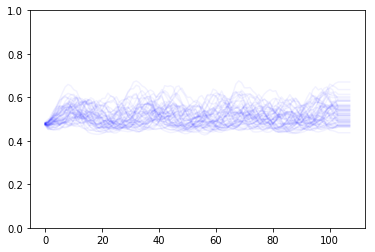

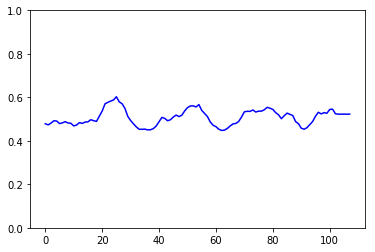

In [46]:
axis_index = 0
plt.figure();
plt.ylim([0,1])
plt.plot(np.arange(108), p_out_full[:, :, axis_index].numpy().T, alpha=0.05, color='blue');
plt.figure();
plt.ylim([0,1])
plt.plot(np.arange(108), p_out_full[0, :, axis_index].numpy().T, alpha=1, color='blue');
